# FRA 503: Deep Reinforcement Learning
# Homework 1

## Done by
- Anawach Anusurain           [65340500056]
- Chanyapak Subsawatkul     [65340500067]

## Part 1: Setting up Multi-armed Bandit.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#### Bandit Class 
1. ฟังชั่นตั้งต้นจะกำหนด
    - จำนวน Bandits
    - hidden reward distributions สำหรับแต่ละ bandit (0-1 แทนโอกาสได้รางวัล 0-100%) 
2.  ฟังชั่น get_reward 
    - รับ bandit_index เพื่อระบุ Bandit ที่ถูกเลือก
    - สุ่มค่าโดยอิงตาม rate ที่กำหนดใน hidden reward distributions ถ้าถูกรางวัลจะ return 1 ไม่ถูกจะ return 0

In [4]:
class Bandit:
    def __init__(self, n_bandits, custom_rewards=None):
        # จำนวน Bandits
        self.n_bandits = n_bandits

        if custom_rewards is None:
            # สร้าง hidden reward distributions สำหรับแต่ละ bandit (สุ่มค่าความน่าจะเป็นระหว่าง 0 ถึง 1)
            self.reward_distributions = np.random.uniform(0, 1, self.n_bandits)
        else:
            # print(len(custom_rewards),n_bandits)
            if len(custom_rewards) == n_bandits:
                # ใช้ custom rewards ที่ผู้ใช้ให้มา
                self.reward_distributions = np.array(custom_rewards)
            else:
                raise ValueError("Custom rewards must be an array of length equal to n_bandits.")

    def get_reward(self, bandit_index):
        if 0 <= bandit_index < self.n_bandits:
            # สุ่มรางวัล: 1 (ถูกรางวัล) หรือ 0 (ไม่ถูกรางวัล) ตามความน่าจะเป็น
            return 1 if np.random.rand() < self.reward_distributions[bandit_index] else 0
            
            
        else:
            raise ValueError("Bandit index out of range!")



#### Agent Class 
1. ฟังชั่นตั้งต้นจะกำหนด
    - จำนวน Bandits
    - Learning Rate
    - Q-value
    - ค่าคงที่สำหรับ UCB
    - จำนวน timestep ทั้งหมด
    - action_probs ความน่าจะเป็นในการเลือกครั้งแรกจะเท่ากันทุก  bandit


2. ฟังชั่น select_action ใช้ในการเลือก bandits โดยตั้งต้นจะให้ใช้ UCB 
    - Epsilon-Greedy 
        
        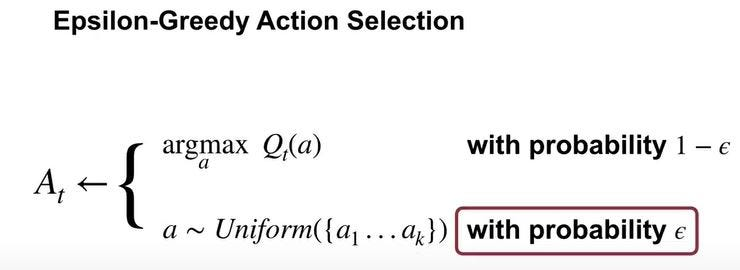

        
    - Upper Confidence Bound (UCB)
        
        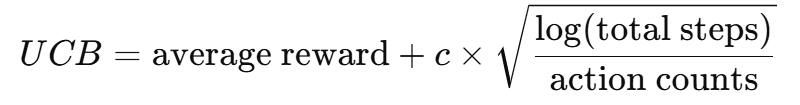



3. ฟังชั่น update

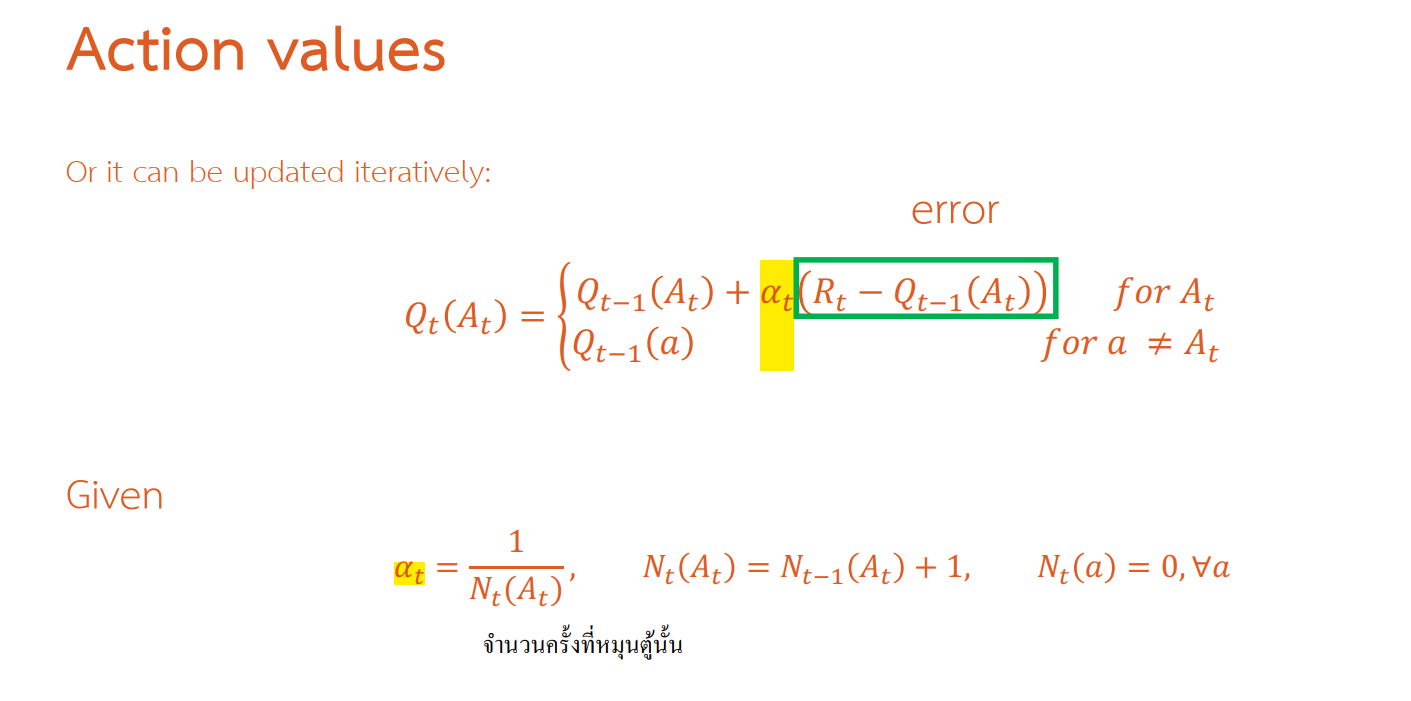




In [5]:
class EpsilonGreedyAgent:
    def __init__(self, n_bandits, epsilon=0.5):
        self.n_bandits = n_bandits
        self.q_values = np.zeros(n_bandits)  # Estimated Q-values
        self.action_counts = np.zeros(n_bandits)  # Number of times each action is taken
        self.epsilon = epsilon  # Exploration rate
        self.total_steps = 0

        # บันทึกประวัติ Q-values ของแต่ละ bandit
        self.q_values_history = [[] for _ in range(n_bandits)]

    def select_action(self):
        """
        เลือก Bandit โดยใช้อัลกอริทึม Epsilon-Greedy
        """
        self.total_steps += 1

        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_bandits)  # Exploration
        else:
            return np.argmax(self.q_values)  # Exploitation

    def update(self, action, reward):
        """
        อัปเดต Q-value และจำนวนครั้งที่เลือก Bandit
        """
        self.action_counts[action] += 1
        # อัปเดตค่า Q-value แบบ incremental
        self.q_values[action] += (reward - self.q_values[action]) / self.action_counts[action]

        # บันทึก Q-value ของทุก bandit ใน timestep ปัจจุบัน
        for i in range(self.n_bandits):
            self.q_values_history[i].append(self.q_values[i])


class UCBAgent:
    def __init__(self, n_bandits, c=2):
        self.n_bandits = n_bandits
        self.q_values = np.zeros(n_bandits)  # Estimated Q-values
        self.action_counts = np.zeros(n_bandits)  # Number of times each action is taken
        self.c = c  # Exploration parameter for UCB
        self.total_steps = 0

        # บันทึกประวัติ Q-values ของแต่ละ bandit
        self.q_values_history = [[] for _ in range(n_bandits)]

    def select_action(self):
        """
        เลือก Bandit โดยใช้อัลกอริทึม Upper Confidence Bound (UCB)
        """
        self.total_steps += 1
        ucb_values = np.zeros(self.n_bandits)

        for i in range(self.n_bandits):
            if self.action_counts[i] > 0:
                confidence = self.c * np.sqrt(np.log(self.total_steps) / (self.action_counts[i]))
                ucb_values[i] = self.q_values[i] + confidence
            else:
                return i  # เลือก Bandit ที่ยังไม่เคยถูกเลือก

        return np.argmax(ucb_values)

    def update(self, action, reward):
        """
        อัปเดต Q-value และจำนวนครั้งที่เลือก Bandit
        """
        self.action_counts[action] += 1
        # อัปเดตค่า Q-value แบบ incremental
        self.q_values[action] += (reward - self.q_values[action]) / self.action_counts[action]

        # บันทึก Q-value ของทุก bandit ใน timestep ปัจจุบัน
        for i in range(self.n_bandits):
            self.q_values_history[i].append(self.q_values[i])

In [ ]:
def run_experiment(n_bandits, n_steps, c=2, epsilon=0.5, method="UCB", custom_rewards=None):
    # Initialize the bandit environment
    bandit = Bandit(n_bandits, custom_rewards)

    # Initialize the appropriate agent based on the method
    if method == "UCB":
        agent = UCBAgent(n_bandits, c)
    elif method == "Epsilon-Greedy":
        agent = EpsilonGreedyAgent(n_bandits, epsilon)
    else:
        raise ValueError("Invalid method. Choose 'UCB' or 'Epsilon-Greedy'.")

    # Lists to store results
    rewards = []
    cumulative_rewards = []
    actions_selected = []

    for step in range(n_steps):
        # Select action based on the agent's strategy
        action = agent.select_action()

        # Get reward from the bandit
        reward = bandit.get_reward(action)

        # Update the agent with the observed reward
        agent.update(action, reward)

        # Record results
        rewards.append(reward)
        cumulative_rewards.append(np.sum(rewards))  # Cumulative reward
        actions_selected.append(action)

    return rewards, cumulative_rewards, bandit.reward_distributions, actions_selected, agent.q_values_history

In [7]:
def plot_q_values(q_values_history, n_bandits):
    plt.figure(figsize=(6,4))

    for i in range(n_bandits):
        plt.plot(q_values_history[i], label=f"Bandit {i+1}")

    plt.xlabel("Timesteps")
    plt.ylabel("Estimated Action Value (q)")
    plt.title("Timestep vs. Q-values for Each Bandit")
    plt.legend()
    plt.grid()
    plt.show()

## Part 2: Implementing epsilon-greedy algorithm.

## Experimental

**hypothesize**
1. If epsilon approaches 0, the agent will fail to explore sufficiently and may not find the most rewarded bandit.
2. If epsilon approaches to 1, the agent will continuously observe (exploit) the bandits without sufficient exploration, also failing to find the most rewarded bandit.

**Observation** : We analyzed the average reward for each epsilon value 3 times by change the most high reward around bandits and also oserve a graph's trend.

We conducted an experiment by running an epsilon-greedy algorithm with the following epsilon values:[0,0.01, 0.1, 0.25, 0.5, 0.75, 1]. Each value was tested 3 times, 

1st : [0.1  0.15 0.2  0.5  0.8 ] อัตราการถูกรางวัลที่ดีที่สุดอยู่ที่ตู้สุดท้าย

2nd : [0.1  0.15 0.8  0.5  0.2 ] อัตราการถูกรางวัลที่ดีที่สุดอยู่ที่ตู้ตรงกลาง

3rd : [0.8  0.15 0.2  0.5  0.1 ] อัตราการถูกรางวัลที่ดีที่สุดอยู่ที่ตู้แรก

epsilon = 0: Average reward = 0.09
epsilon = 0.01: Average reward = 0.76
epsilon = 0.1: Average reward = 0.75
epsilon = 0.25: Average reward = 0.69
epsilon = 0.5: Average reward = 0.57
epsilon = 0.75: Average reward = 0.47
epsilon = 1: Average reward = 0.35
epsilon = 0: Average reward = 0.10
epsilon = 0.01: Average reward = 0.78
epsilon = 0.1: Average reward = 0.75
epsilon = 0.25: Average reward = 0.69
epsilon = 0.5: Average reward = 0.58
epsilon = 0.75: Average reward = 0.46
epsilon = 1: Average reward = 0.34
epsilon = 0: Average reward = 0.80
epsilon = 0.01: Average reward = 0.80
epsilon = 0.1: Average reward = 0.75
epsilon = 0.25: Average reward = 0.68
epsilon = 0.5: Average reward = 0.57
epsilon = 0.75: Average reward = 0.47
epsilon = 1: Average reward = 0.35


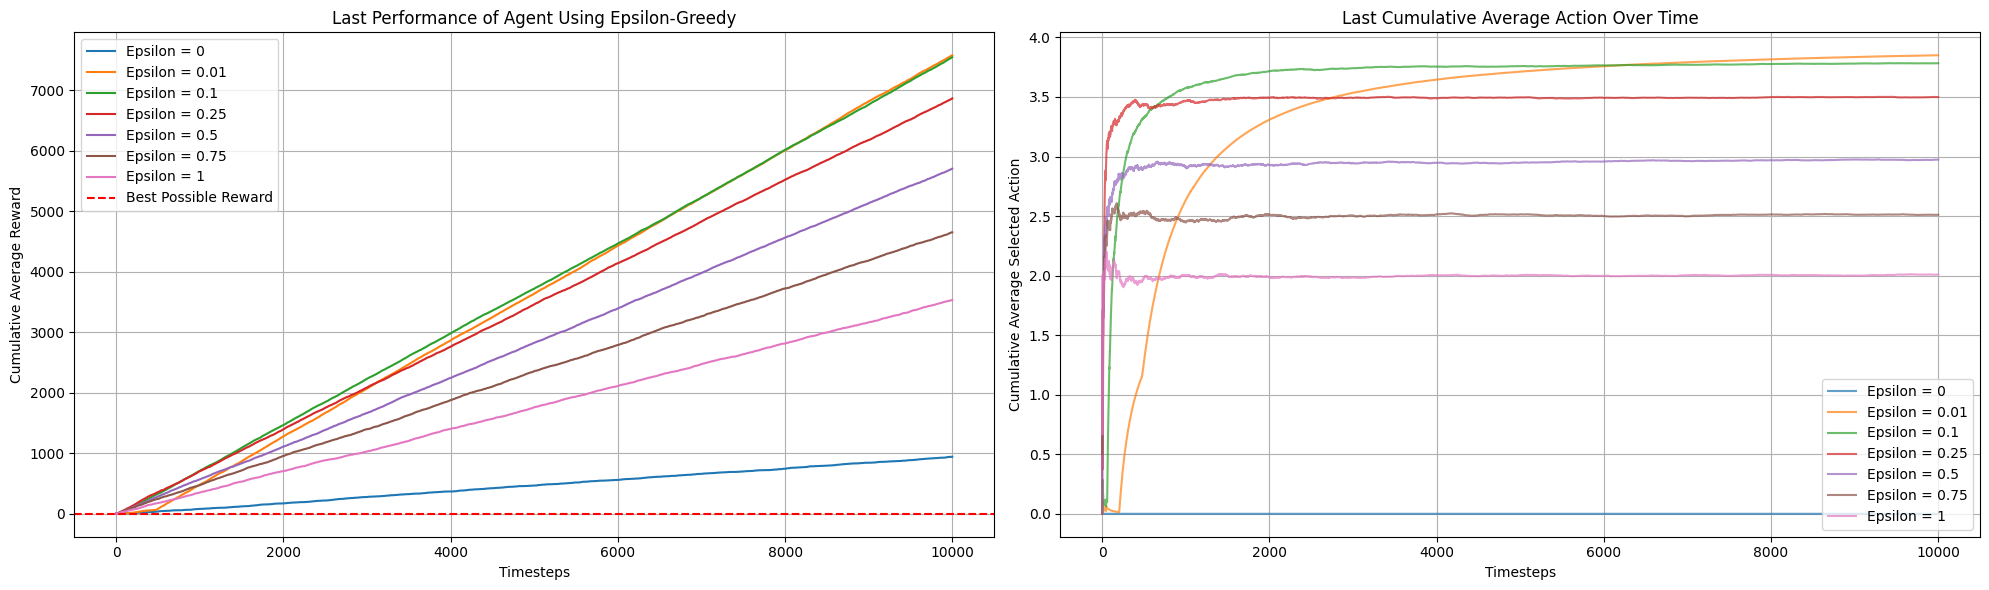

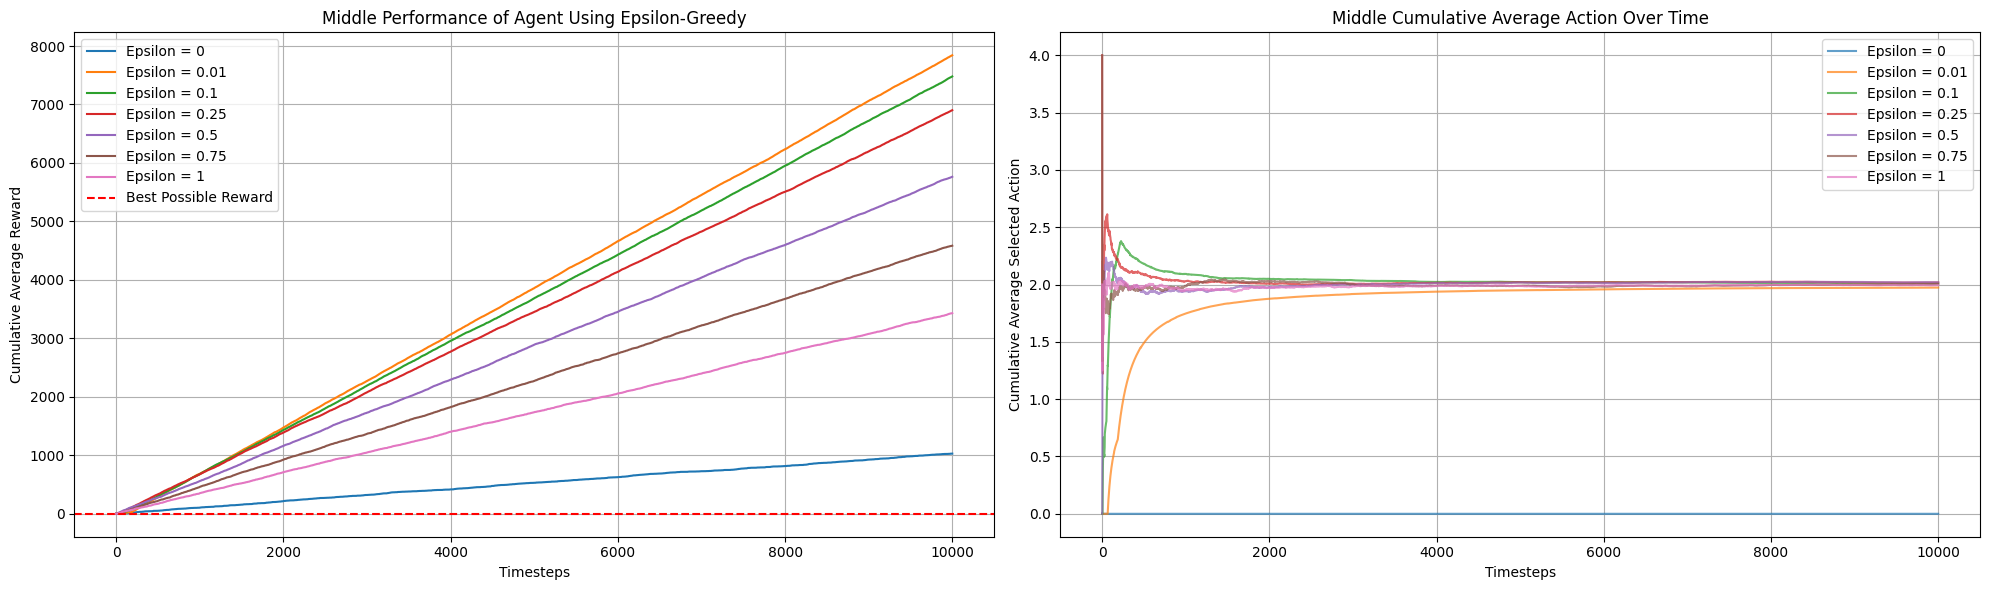

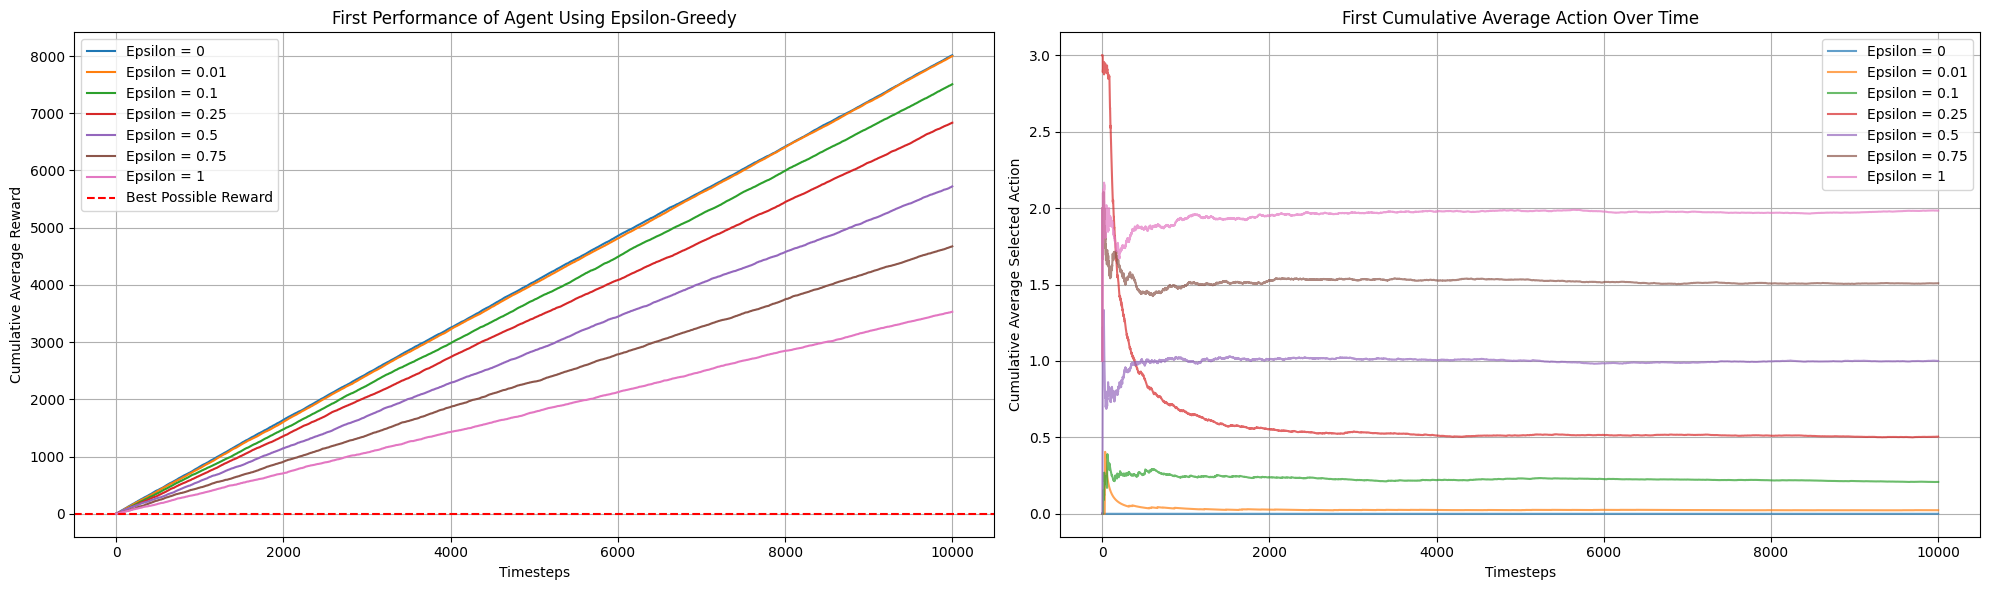


Plotting Q-values for Epsilon = 0(Last)


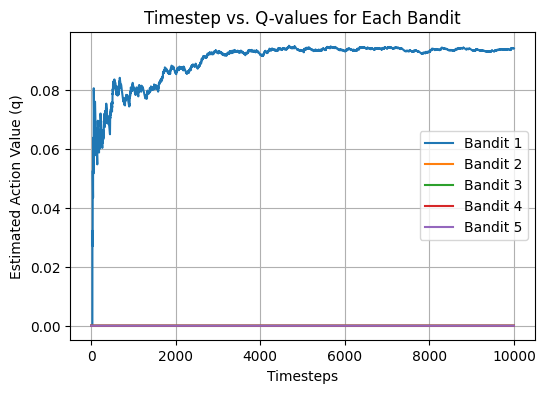


Plotting Q-values for Epsilon = 0.01(Last)


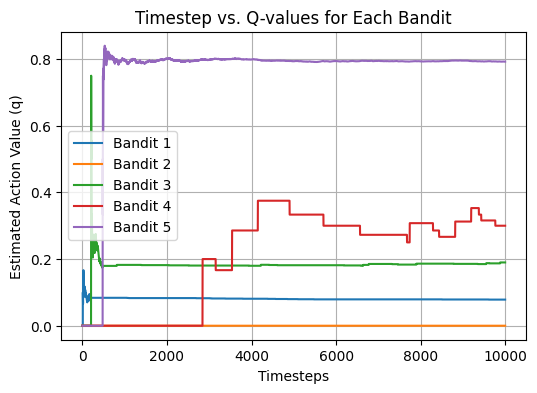


Plotting Q-values for Epsilon = 0.1(Last)


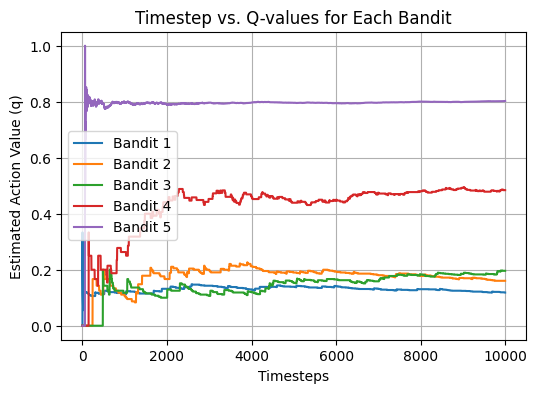


Plotting Q-values for Epsilon = 0.25(Last)


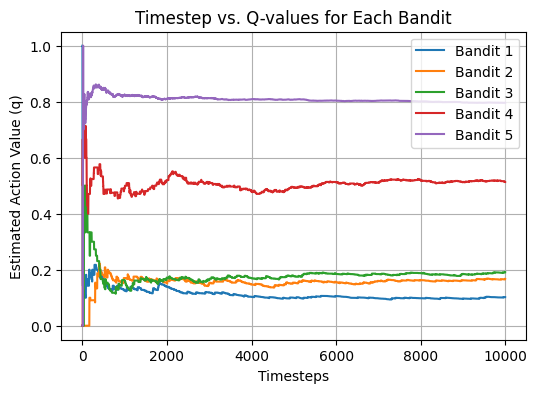


Plotting Q-values for Epsilon = 0.5(Last)


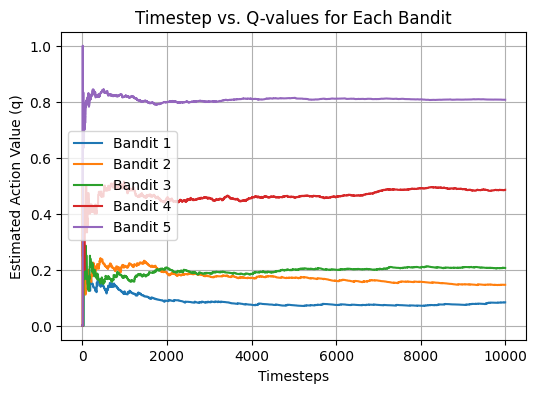


Plotting Q-values for Epsilon = 0.75(Last)


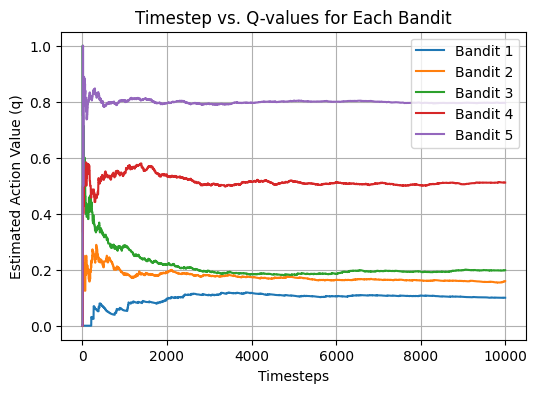


Plotting Q-values for Epsilon = 1(Last)


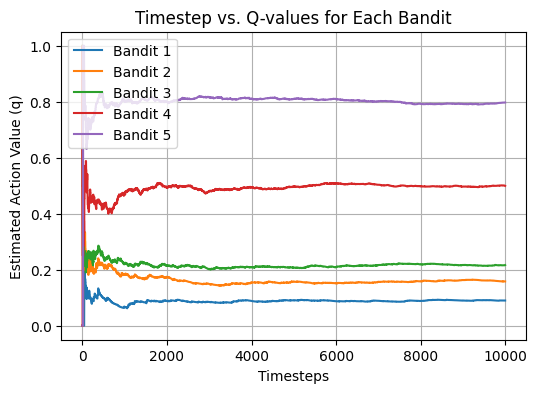


Plotting Q-values for Epsilon = 0 (middle)


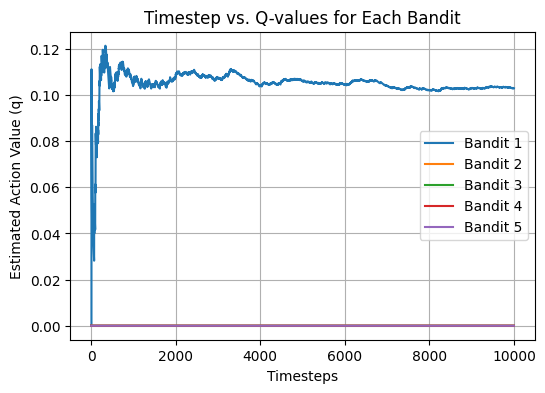


Plotting Q-values for Epsilon = 0.01 (middle)


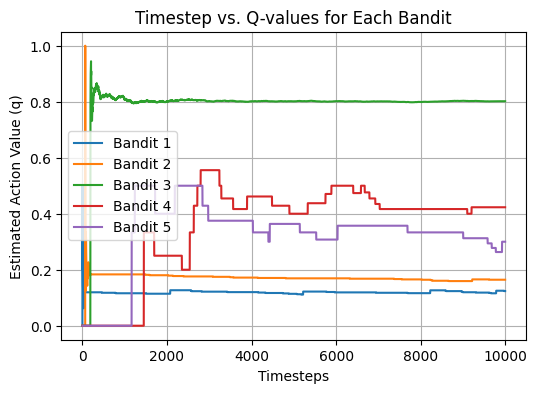


Plotting Q-values for Epsilon = 0.1 (middle)


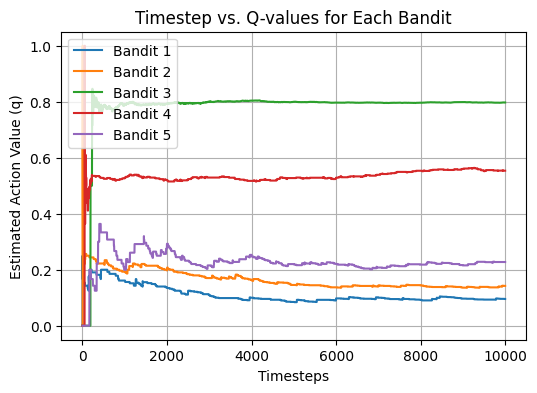


Plotting Q-values for Epsilon = 0.25 (middle)


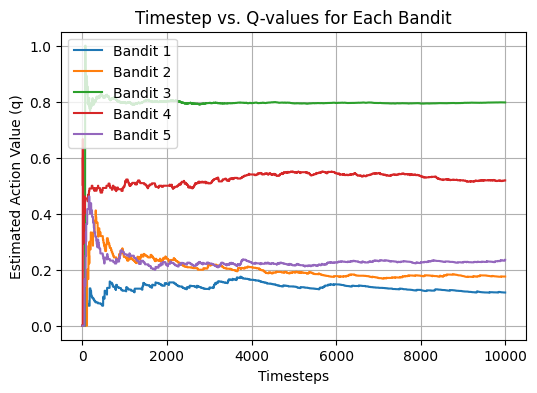


Plotting Q-values for Epsilon = 0.5 (middle)


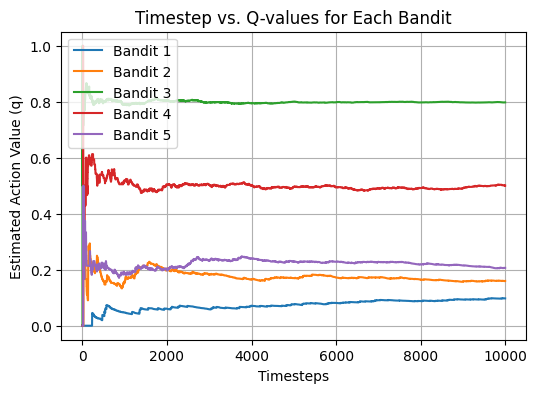


Plotting Q-values for Epsilon = 0.75 (middle)


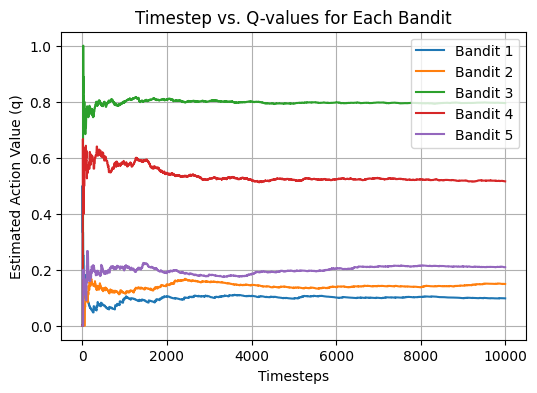


Plotting Q-values for Epsilon = 1 (middle)


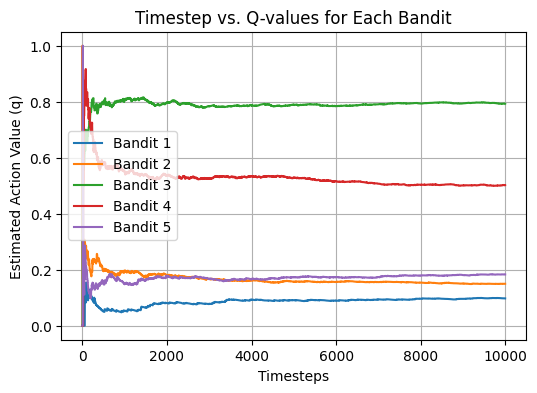


Plotting Q-values for Epsilon = 0 (first)


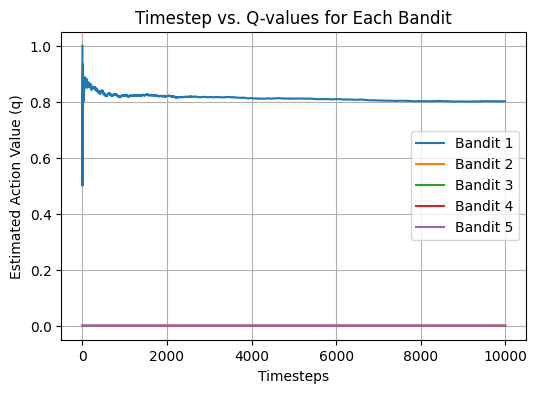


Plotting Q-values for Epsilon = 0.01 (first)


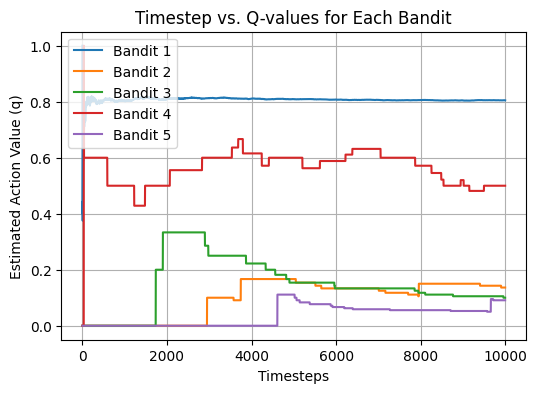


Plotting Q-values for Epsilon = 0.1 (first)


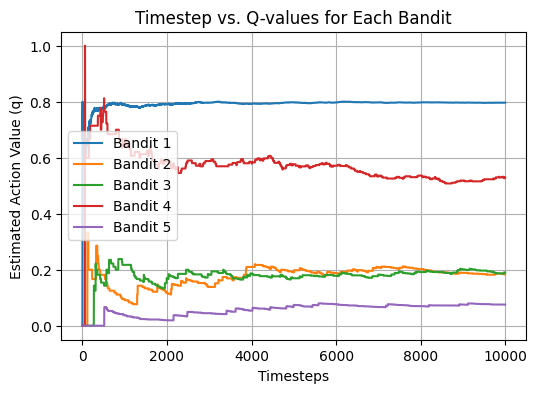


Plotting Q-values for Epsilon = 0.25 (first)


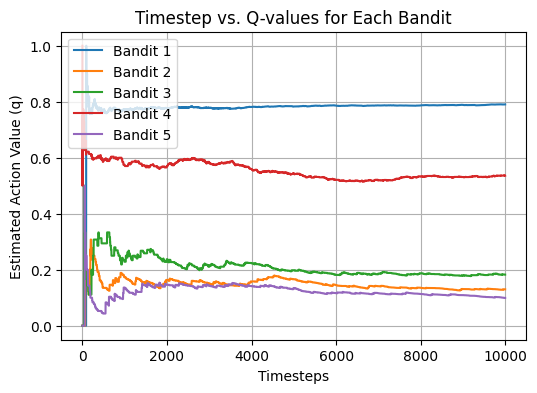


Plotting Q-values for Epsilon = 0.5 (first)


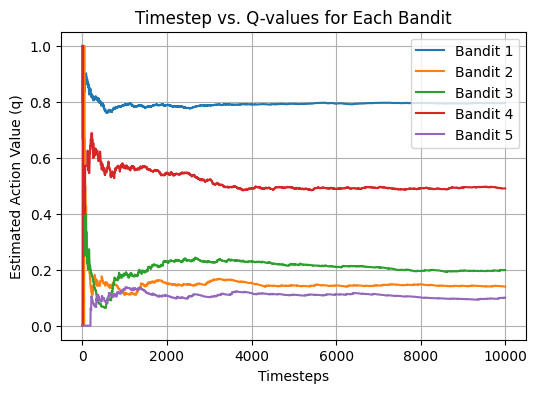


Plotting Q-values for Epsilon = 0.75 (first)


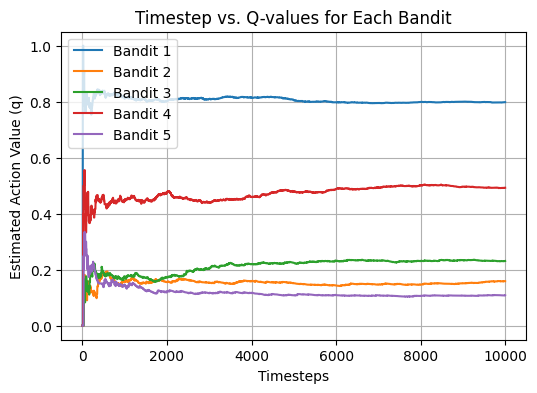


Plotting Q-values for Epsilon = 1 (first)


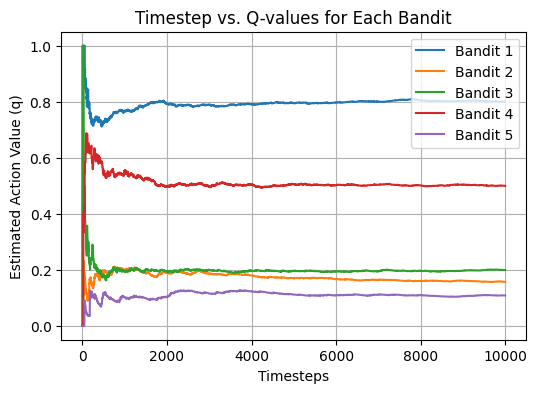

In [11]:
if __name__ == "__main__":

    cumulative_rewards_results = {}
    actions_selected_results = {}
    q_values_history_results = {}

    cumulative_rewards_results1 = {}
    actions_selected_results1 = {}
    q_values_history_results1 = {}

    cumulative_rewards_results2 = {}
    actions_selected_results2 = {}
    q_values_history_results2 = {}

    n_bandits = 5     
    n_steps = 10000    
    epsilon_values = [0, 0.01, 0.1, 0.25, 0.5, 0.75, 1]
    
    method = "Epsilon-Greedy"  

    for epsilon in epsilon_values:
        rewards = [0.1, 0.15, 0.2, 0.5, 0.8] 
        custom_rewards = rewards.copy()
        rewards, cumulative_rewards, hidden_rewards, actions_selected, q_values_history = run_experiment(
            n_bandits=n_bandits, n_steps=n_steps, epsilon=epsilon, method=method, custom_rewards=custom_rewards
        )
        cumulative_rewards_results[epsilon] = cumulative_rewards
        actions_selected_results[epsilon] = actions_selected
        q_values_history_results[epsilon] = q_values_history
        print(f"epsilon = {epsilon}: Average reward = {np.mean(rewards):.2f}")
    
    for epsilon in epsilon_values:
        rewards = [0.1, 0.15, 0.8, 0.5, 0.2] 
        custom_rewards = rewards.copy()
        rewards, cumulative_rewards, hidden_rewards, actions_selected, q_values_history = run_experiment(
            n_bandits=n_bandits, n_steps=n_steps, epsilon=epsilon, method=method, custom_rewards=custom_rewards
        )
        cumulative_rewards_results1[epsilon] = cumulative_rewards
        actions_selected_results1[epsilon] = actions_selected
        q_values_history_results1[epsilon] = q_values_history
        print(f"epsilon = {epsilon}: Average reward = {np.mean(rewards):.2f}")

    for epsilon in epsilon_values:
        rewards = [0.8, 0.15, 0.2, 0.5, 0.1] 
        custom_rewards = rewards.copy()
        rewards, cumulative_rewards, hidden_rewards, actions_selected, q_values_history = run_experiment(
            n_bandits=n_bandits, n_steps=n_steps, epsilon=epsilon, method=method, custom_rewards=custom_rewards
        )
        cumulative_rewards_results2[epsilon] = cumulative_rewards
        actions_selected_results2[epsilon] = actions_selected
        q_values_history_results2[epsilon] = q_values_history
        print(f"epsilon = {epsilon}: Average reward = {np.mean(rewards):.2f}")

    # --- Plot กราฟเดิม (Cumulative Rewards & Actions) ---
    def plot_results(cumulative_results, actions_results, title):
        fig, axes = plt.subplots(1, 2, figsize=(20, 6))

        # --- Plot Cumulative Rewards ---
        for epsilon, cumulative_rewards in cumulative_results.items():
            axes[0].plot(range(len(cumulative_rewards)), cumulative_rewards, label=f"Epsilon = {epsilon}")

        axes[0].axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
        axes[0].set_title(f"{title} Performance of Agent Using {method}")
        axes[0].set_xlabel("Timesteps")
        axes[0].set_ylabel("Cumulative Average Reward")
        axes[0].legend()
        axes[0].grid()

        # --- Compute and Plot Cumulative Average of Selected Actions ---
        for epsilon, actions_selected in actions_results.items():
            timesteps = np.arange(1, len(actions_selected) + 1)
            cumulative_avg_actions = np.cumsum(actions_selected) / timesteps  

            axes[1].plot(timesteps, cumulative_avg_actions, label=f"Epsilon = {epsilon}", alpha=0.7)

        axes[1].set_title(f"{title} Cumulative Average Action Over Time")
        axes[1].set_xlabel("Timesteps")
        axes[1].set_ylabel("Cumulative Average Selected Action")
        axes[1].legend()
        axes[1].grid()

        plt.tight_layout()
        plt.show()

    # Plot กราฟเดิม
    plot_results(cumulative_rewards_results, actions_selected_results, "Last")
    plot_results(cumulative_rewards_results1, actions_selected_results1, "Middle")
    plot_results(cumulative_rewards_results2, actions_selected_results2, "First")

    # --- Plot Q-values ---
    for epsilon in epsilon_values:
        print(f"\nPlotting Q-values for Epsilon = {epsilon}(Last)")
        plot_q_values(q_values_history_results[epsilon], n_bandits)

    for epsilon in epsilon_values:
        print(f"\nPlotting Q-values for Epsilon = {epsilon} (middle)")
        plot_q_values(q_values_history_results1[epsilon], n_bandits)

    for epsilon in epsilon_values:
        print(f"\nPlotting Q-values for Epsilon = {epsilon} (first)")
        plot_q_values(q_values_history_results2[epsilon], n_bandits)


### Result Analysis


#### 1.the highest reward is associated with the last option [0.1, 0.15, 0.2, 0.5, **0.8**] 
Time step 10,000
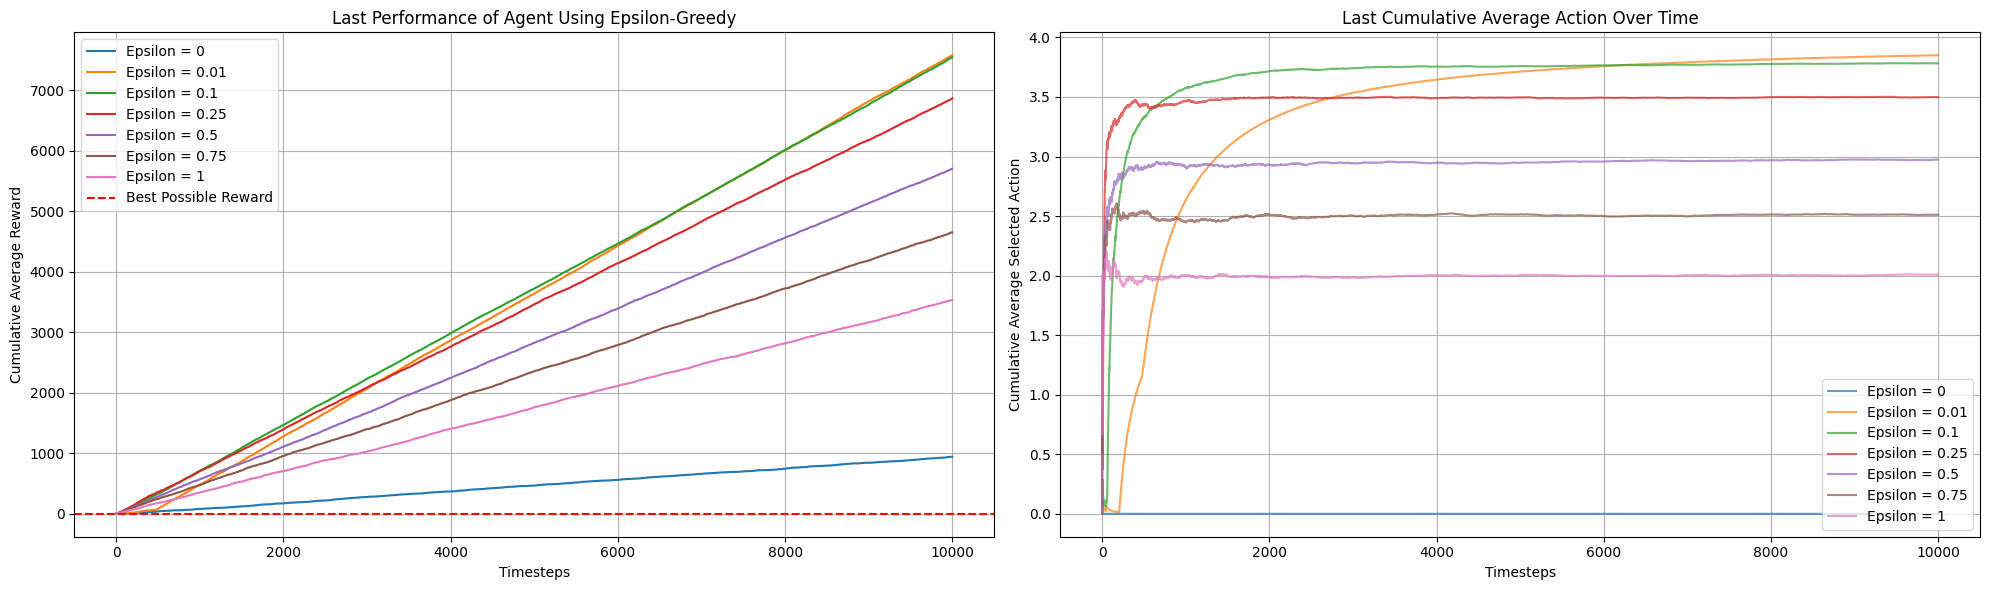

In this experiment, the Bandit problem is designed with hidden reward distributions as follows
[0.1, 0.15, 0.2, 0.5, 0.8], where the highest reward is associated with the last option.

From the results, we observe that

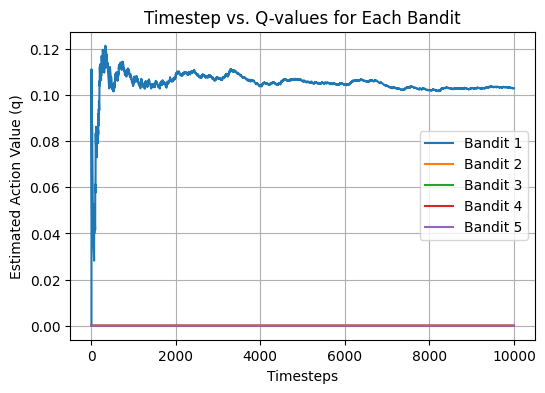
- When Epsilon = 0 (no exploration at all), the agent selects the machine that initially provides the highest reward it encounters. It does not attempt to explore further, resulting in a low cumulative reward since it fails to discover the best machine.
Conversely, 

Epsilon = 0.25, 1

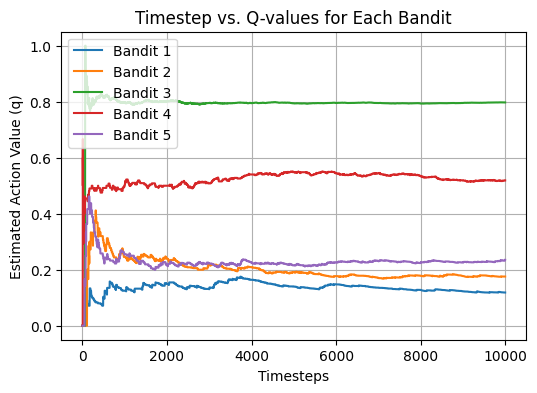 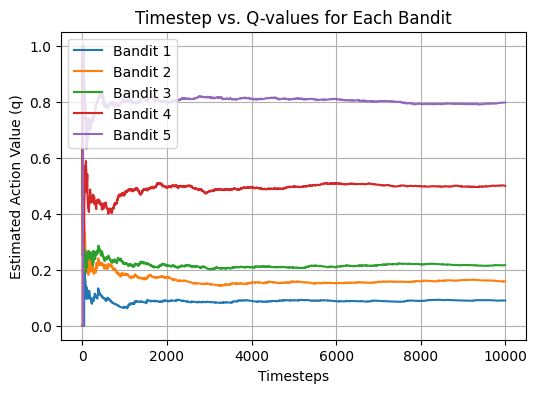
- when Epsilon > 0.25 Agent start to expolring more, the agent discovers the machine with the highest hidden reward. However, since it continues exploring indefinitely instead of exploiting the best option, the cumulative reward remains low.

**Best Epsilon for This Case**

Epsilon = 0.01, 0.1

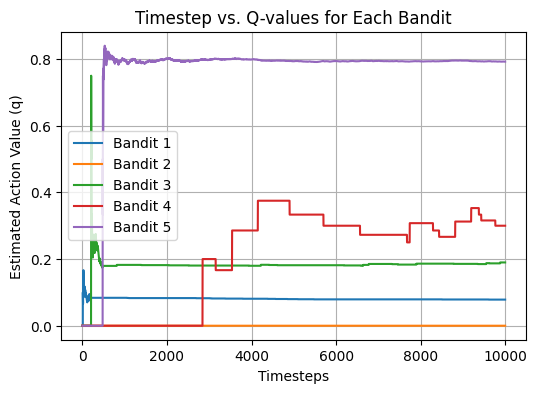 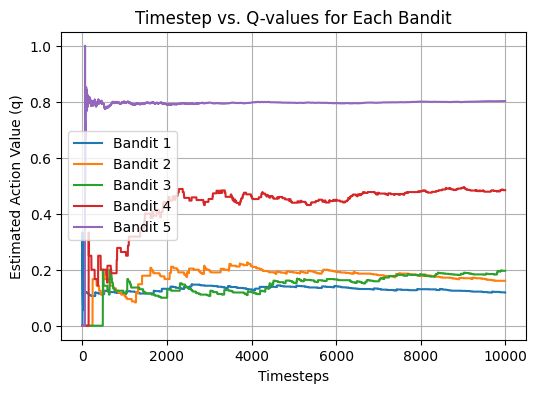

Epsilon = 0.01 or 0.1 gives the highest cumulative reward. These values help the agent explore enough to find the best machine but still focus on using it efficiently. This avoids getting stuck too early (like in ε = 0) and too much randomness (like in ε = 1).




#### 2. the highest reward is associated with the third option (middle position) [0.1,  0.15, **0.8**,  0.5,  0.2 ]
Time step 10,000

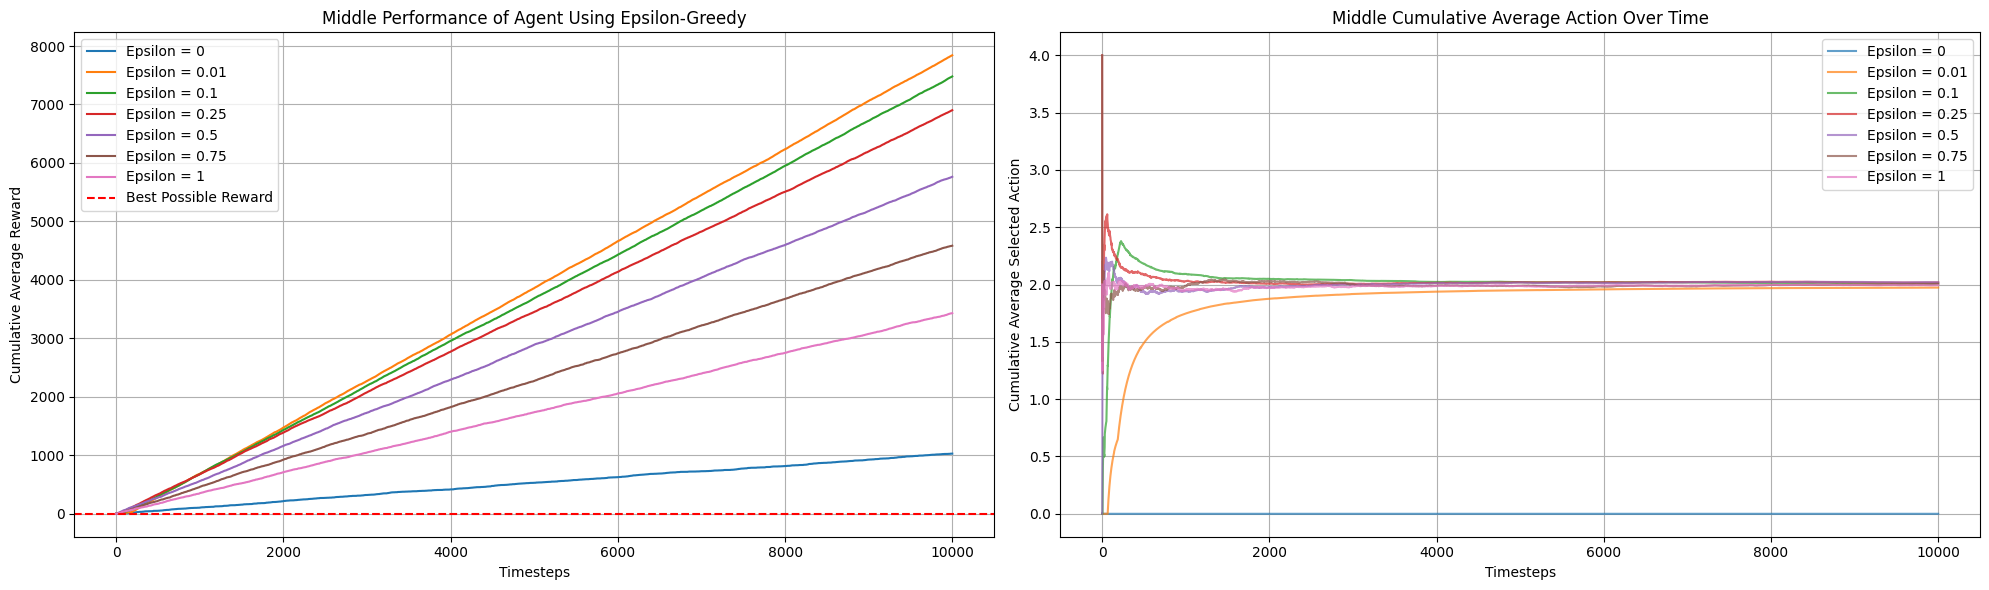

In this experiment, the Bandit problem is designed with hidden reward distributions as follows
[0.1  0.15 0.8  0.5  0.2 ], where the highest reward is associated with the third option (middle position).

From the results, we observe that

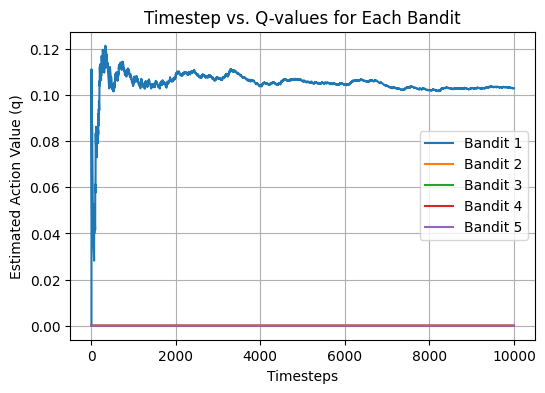

- When Epsilon = 0 (no exploration at all), the agent selects the machine that initially provides the highest reward it encounters. It does not attempt to explore further, resulting in a low cumulative reward since it fails to discover the best machine.
Conversely, 

Epsilon = 0.25, 1

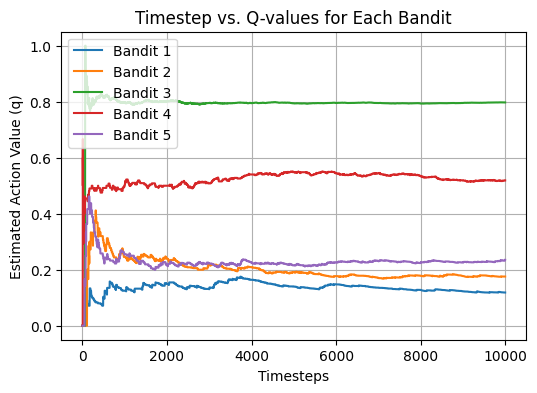 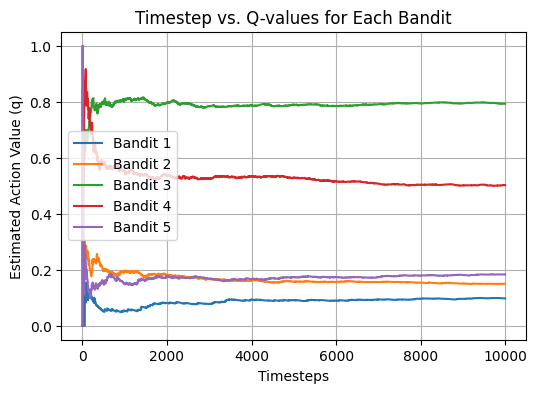

- when Epsilon > 0.25 Agent start to expolring more, the agent discovers the machine with the highest hidden reward. However, since it continues exploring indefinitely instead of exploiting the best option, the cumulative reward remains low. You will can see a Epsilon = 1 Has a too much q-value of bandit 4 at the initial. 

**Best Epsilon for This Case**

Epsilon = 0.01, 0.1

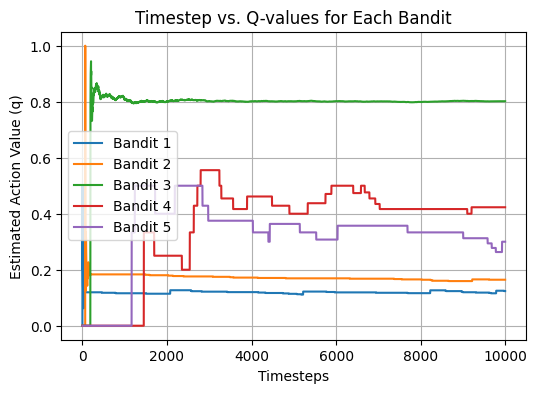 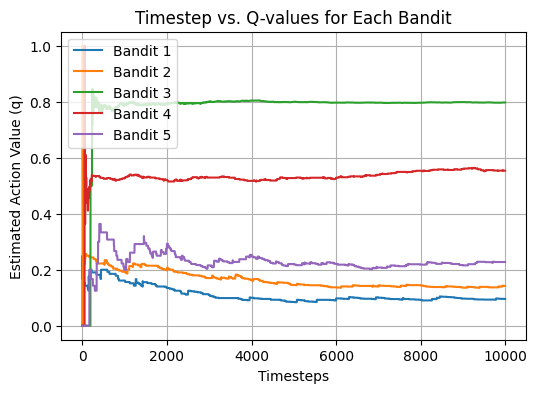

Epsilon = 0.01, 0.1 gives the highest cumulative reward. These values help the agent explore enough to find the best machine but still focus on using it efficiently

#### 3.  the highest reward is in the first option [**0.8**, 0.15, 0.2, 0.5, 0.1] 
Time Step 10,000

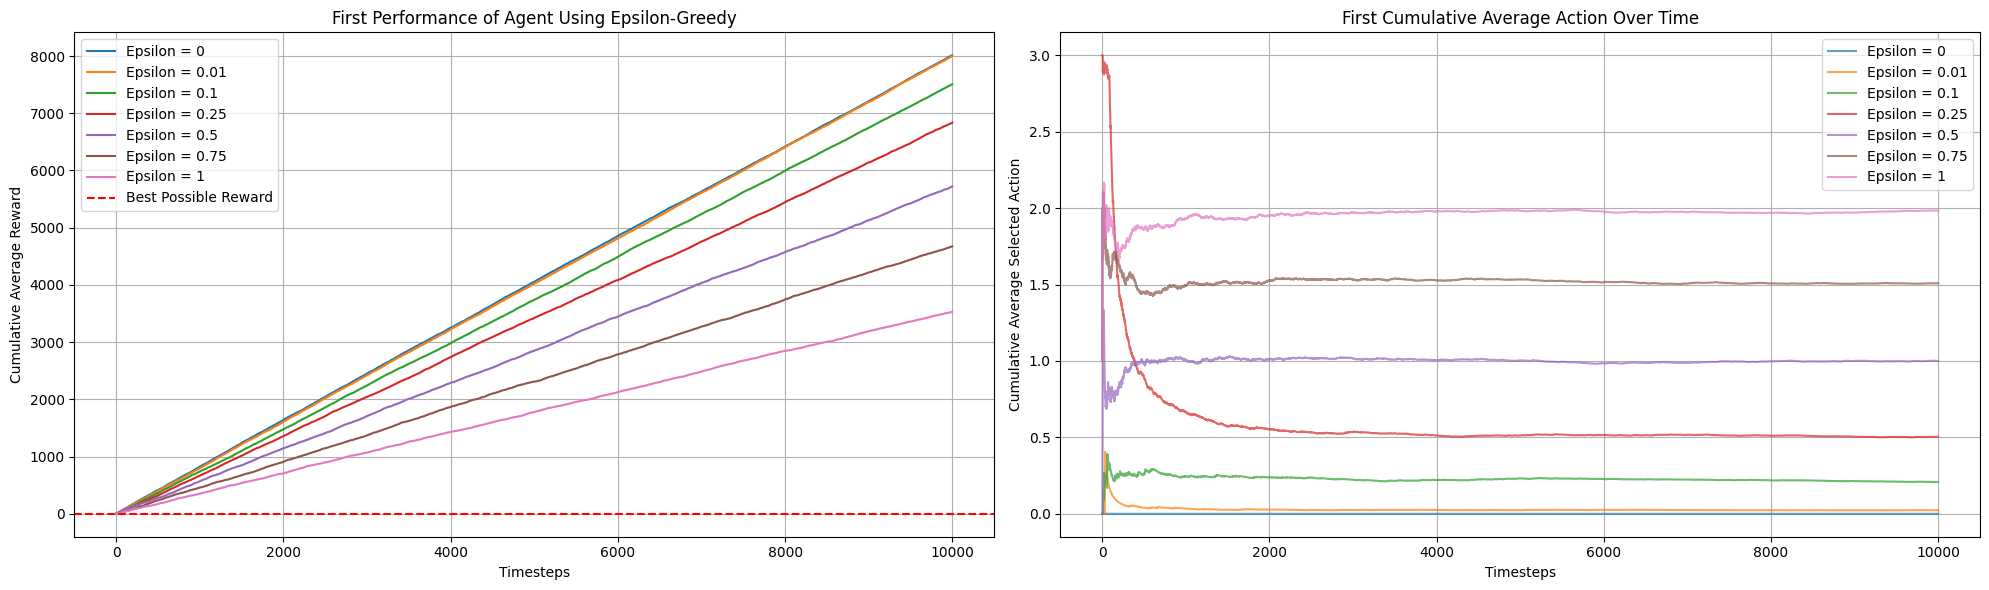

In this experiment, the Bandit problem is designed with hidden reward distributions as follows
[0.8, 0.15, 0.2, 0.5, 0.1] , where the highest reward is associated with the middle option.

From the results, we observe that

Epsilon = 0.1, 1

 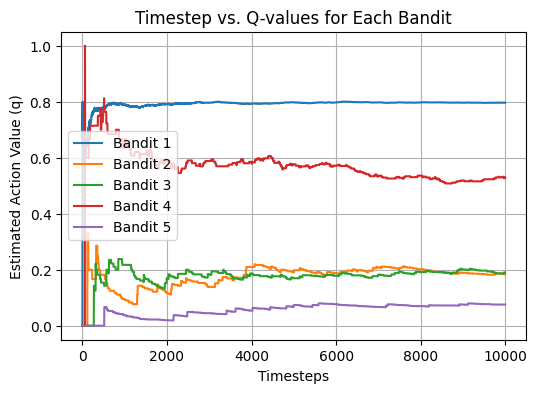 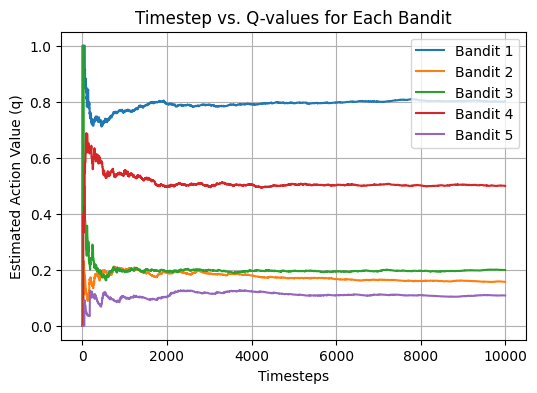

- when Epsilon > 0.1 Agent start to expolring more, the agent discovers the machine with the highest hidden reward. However, since it continues exploring indefinitely instead of exploiting the best option, the cumulative reward remains low. You will can see a Epsilon = 1 Has a too much q-value of bandit 3 at the initial. 


**Best Epsilon for This Case**

Epsilon = 0.01

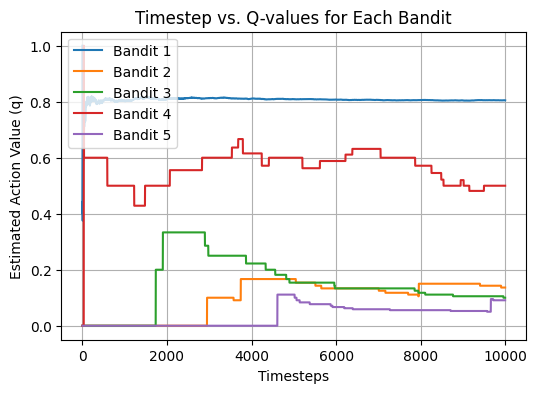

- When Epsilon = 0.01 gives the highest cumulative reward. These values help the agent explore enough to find the best machine but still focus on using it efficiently.

Epsilon = 0

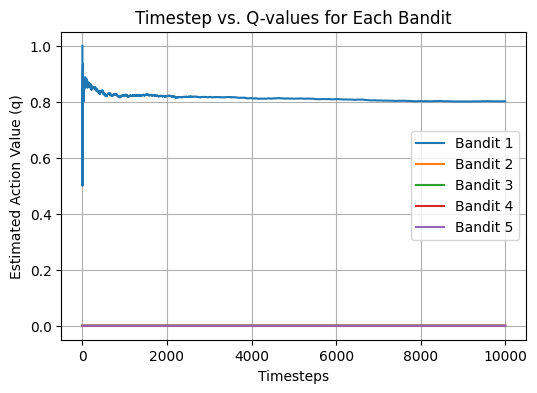

- The agent performs 0% exploration and 100% exploitation. It chooses an action that gives a good reward early on and never tries anything else. If the first choice is not the best, the agent stays stuck with it, leading to low rewards.
- The agent doesn’t try to explore anything and is ready to settle for the option as soon as it gets a reward. Since the highest reward is already in the first option, the agent happens to select the best option by chance. Because it doesn't explore, it sticks to the best option from the start and continues selecting it in every time step, resulting in the highest cumulative reward by luck.


## Summary of UCB
- The experimental results show that when the Epsilon-value approaches 0, the agent balances exploration and exploitation well, leading to higher cumulative rewards. This effect is observed in the range of 0.01 to 0.25.
- If the Epsilon-value exceeds 0.25, cumulative rewards start to decrease due to excessive exploration.
- When Epsilon = 0, the agent fully exploits, resulting in low cumulative rewards. However, an exception occurs when the highest reward is in the first bandit, as the agent happens to select the optimal reward from the start.

**Implications for Multi-Armed Bandit Optimization**
In static environments, a well-tuned ε-greedy strategy (ε ≈ 0.01 - 0.25) ensures efficient learning, allowing the agent to explore early and exploit once the best arm is identified.

## Part 3: Implementing UCB


## Experimental
**hypothesize**
1. If c approaches 0, the agent will fail to explore sufficiently and may not find the most rewarded bandit.
2. If c approaches to infinite, the agent will continuously observe (exploit) the bandits without sufficient exploration, also failing to find the most rewarded bandit.

**Observation** : We analyzed the average reward for each c value 3 times by change the most high reward around bandits 

We conducted an experiment by running an epsilon-greedy algorithm with the following c values:[ 0, 0.01, 0.1, 0.5, 1, 2, 5, 7, 10]. Each value was tested 3 times, 

1st : [0.1  0.15 0.2  0.5  0.8 ]

2nd : [0.1  0.15 0.8  0.5  0.2 ]

3rd : [0.8  0.15 0.2  0.5  0.1 ]

c = 0: Average reward = 0.80
c = 0.01: Average reward = 0.80
c = 0.1: Average reward = 0.80
c = 0.5: Average reward = 0.80
c = 1: Average reward = 0.79
c = 2: Average reward = 0.78
c = 5: Average reward = 0.70
c = 7: Average reward = 0.65
c = 10: Average reward = 0.58
c = 0: Average reward = 0.81
c = 0.01: Average reward = 0.80
c = 0.1: Average reward = 0.79
c = 0.5: Average reward = 0.80
c = 1: Average reward = 0.79
c = 2: Average reward = 0.77
c = 5: Average reward = 0.70
c = 7: Average reward = 0.65
c = 10: Average reward = 0.59
c = 0: Average reward = 0.14
c = 0.01: Average reward = 0.81
c = 0.1: Average reward = 0.80
c = 0.5: Average reward = 0.80
c = 1: Average reward = 0.80
c = 2: Average reward = 0.78
c = 5: Average reward = 0.70
c = 7: Average reward = 0.65
c = 10: Average reward = 0.58


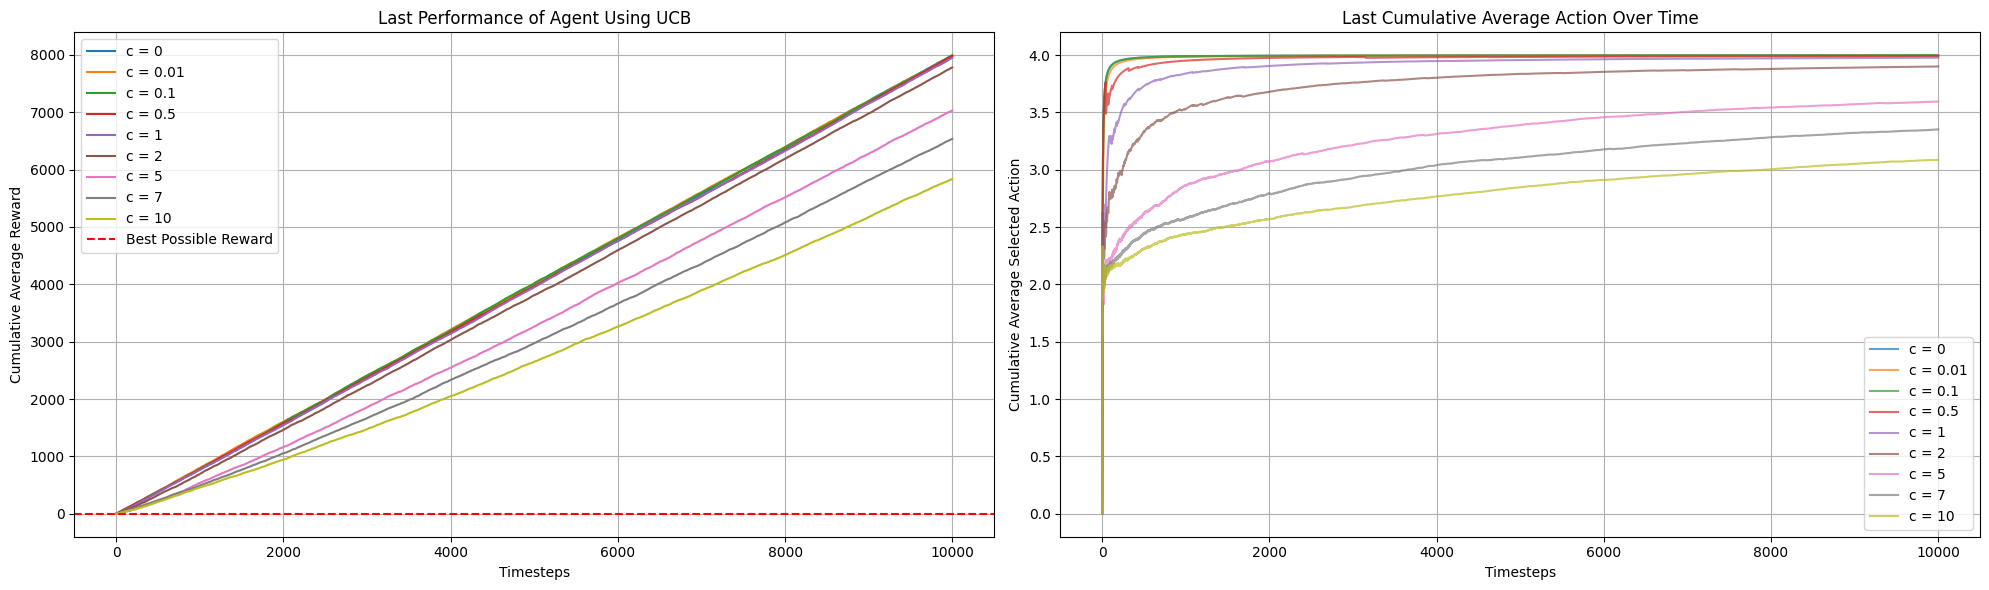

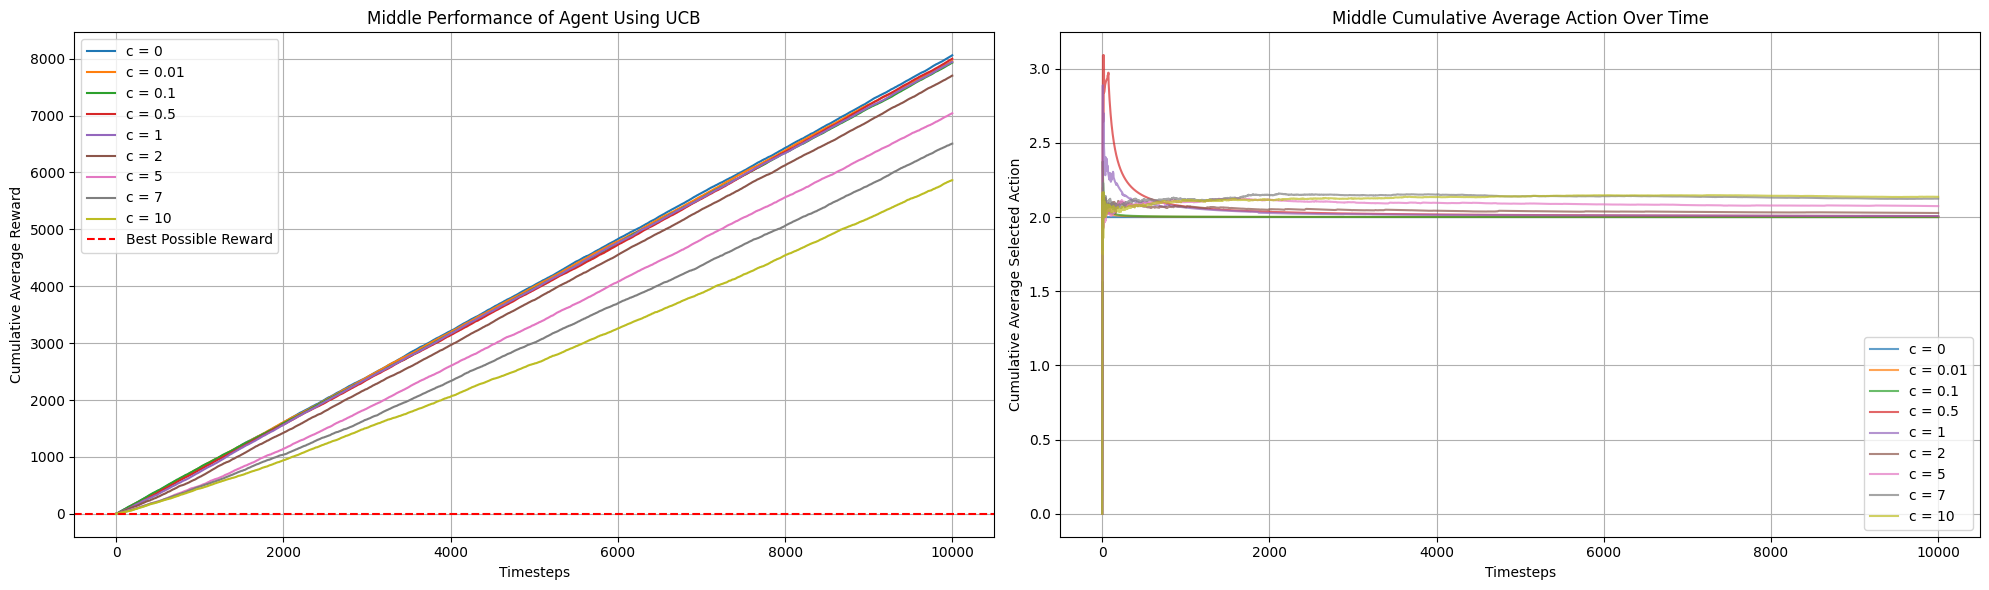

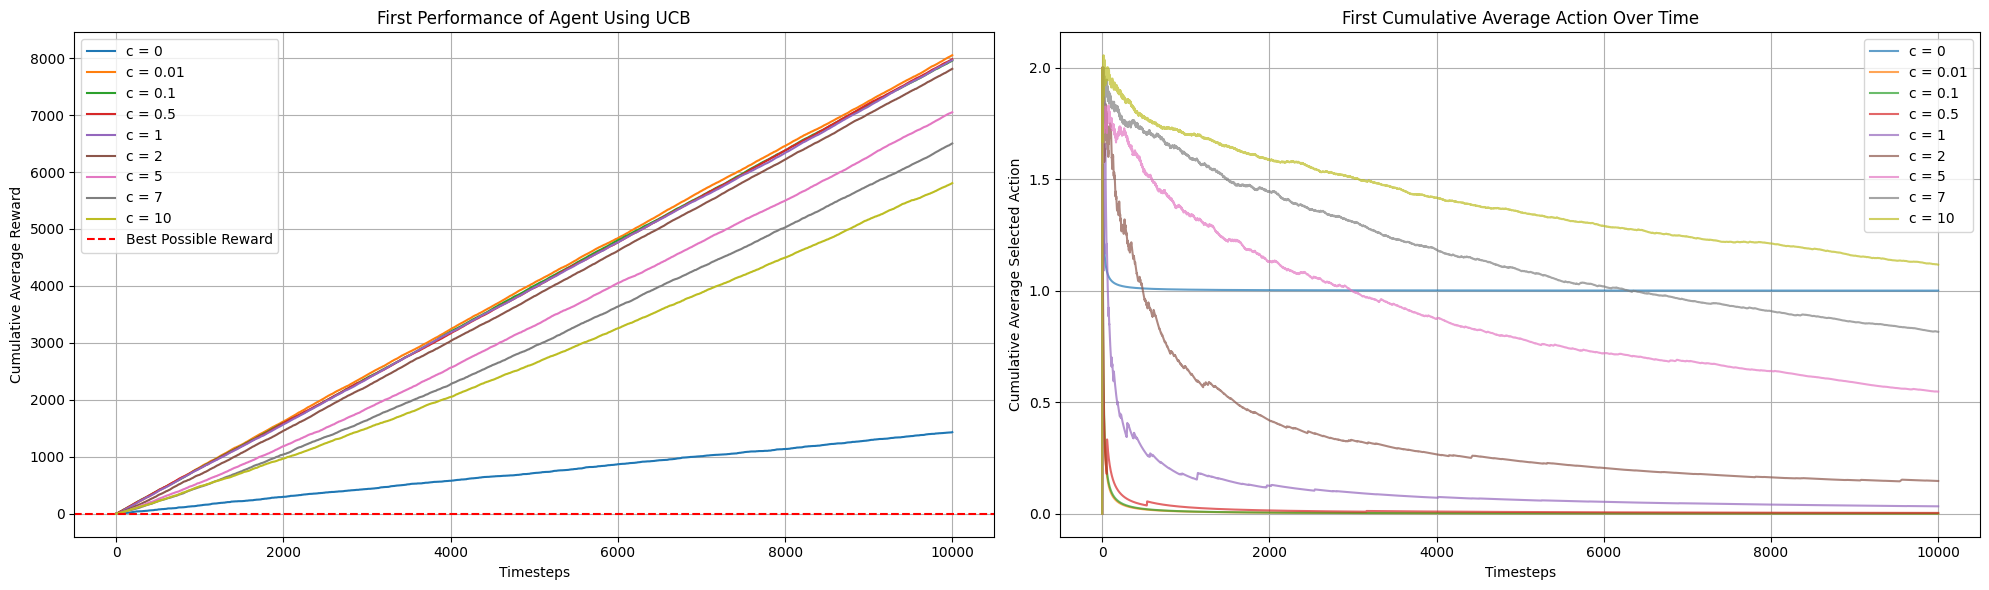


Plotting Q-values for c = 0(Last)


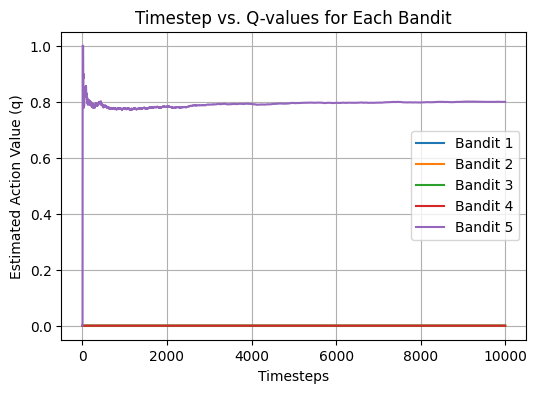


Plotting Q-values for c = 0.01(Last)


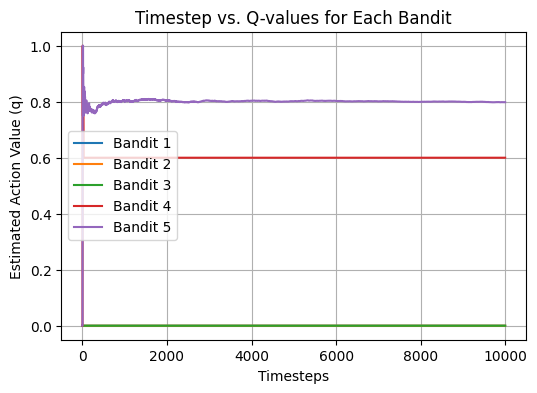


Plotting Q-values for c = 0.1(Last)


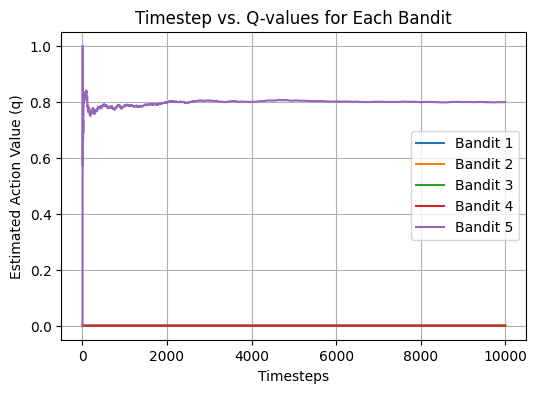


Plotting Q-values for c = 0.5(Last)


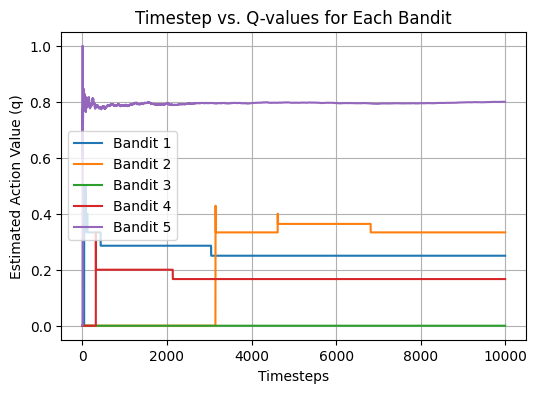


Plotting Q-values for c = 1(Last)


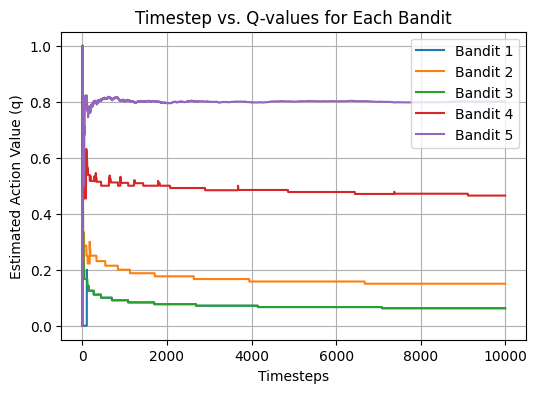


Plotting Q-values for c = 2(Last)


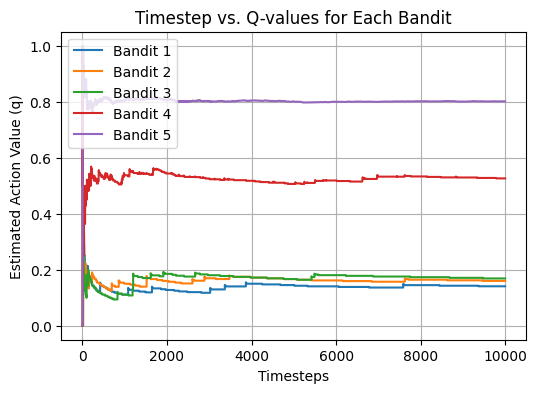


Plotting Q-values for c = 5(Last)


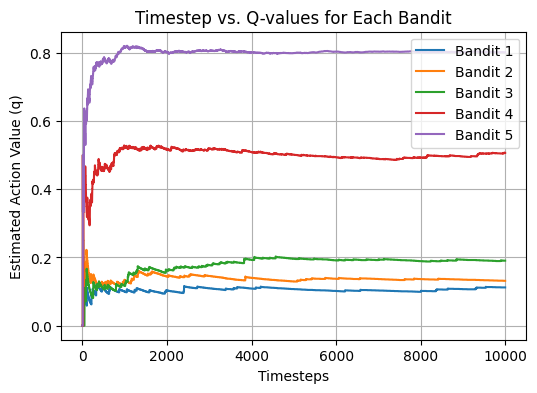


Plotting Q-values for c = 7(Last)


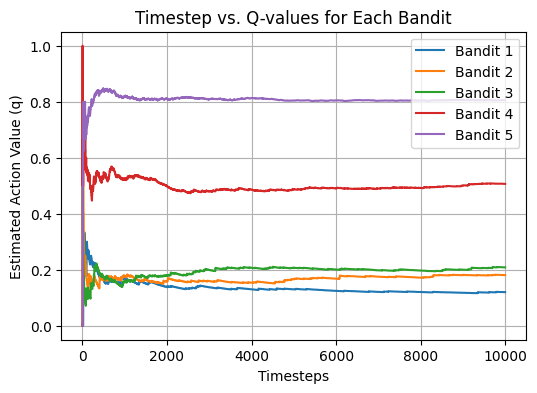


Plotting Q-values for c = 10(Last)


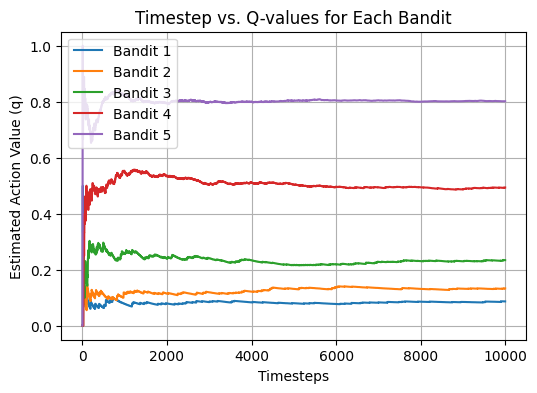


Plotting Q-values for c = 0 (middle)


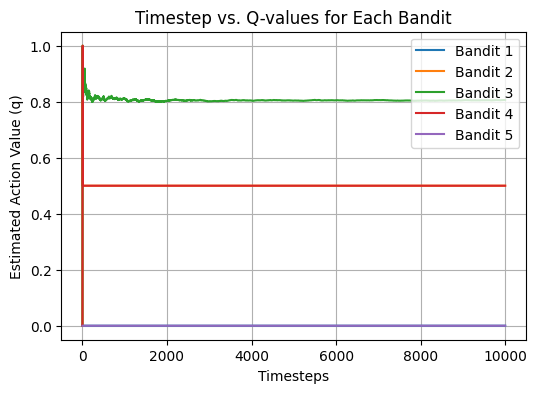


Plotting Q-values for c = 0.01 (middle)


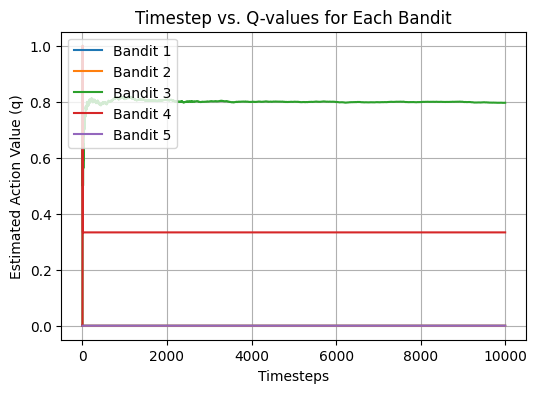


Plotting Q-values for c = 0.1 (middle)


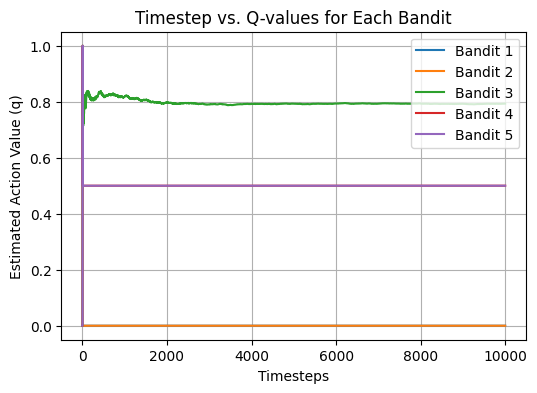


Plotting Q-values for c = 0.5 (middle)


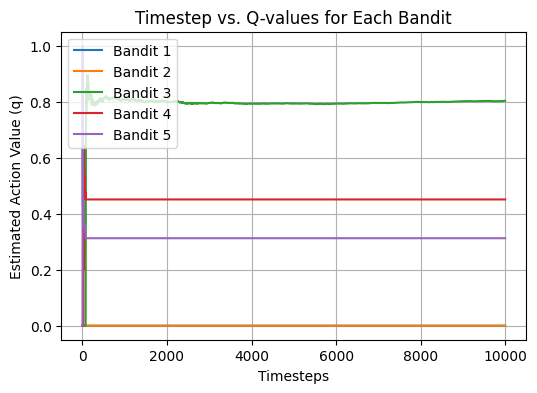


Plotting Q-values for c = 1 (middle)


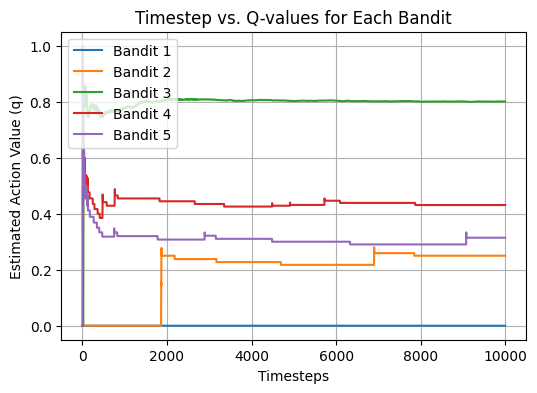


Plotting Q-values for c = 2 (middle)


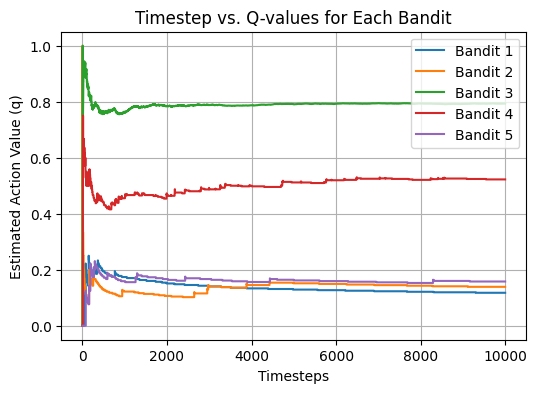


Plotting Q-values for c = 5 (middle)


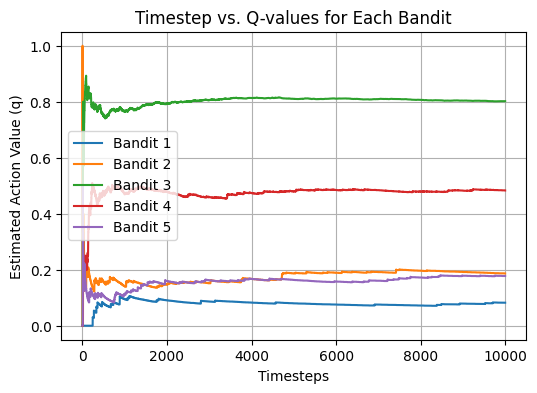


Plotting Q-values for c = 7 (middle)


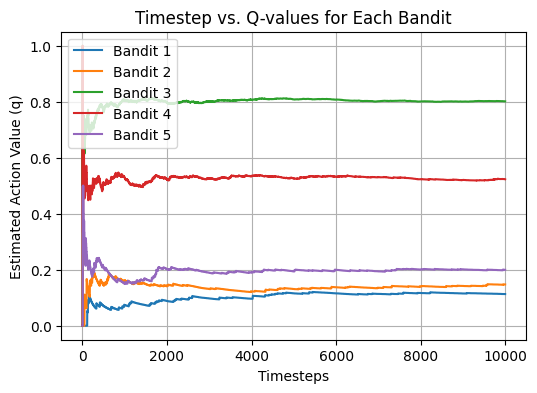


Plotting Q-values for c = 10 (middle)


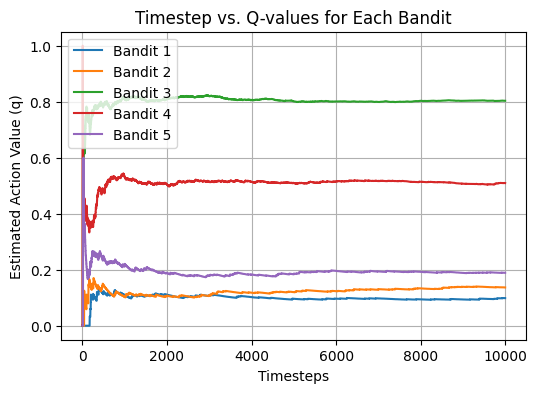


Plotting Q-values for c = 0 (first)


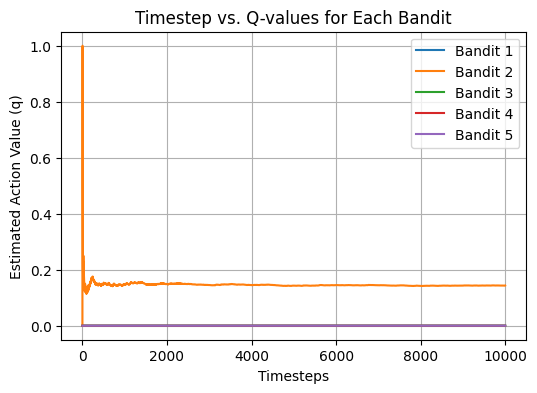


Plotting Q-values for c = 0.01 (first)


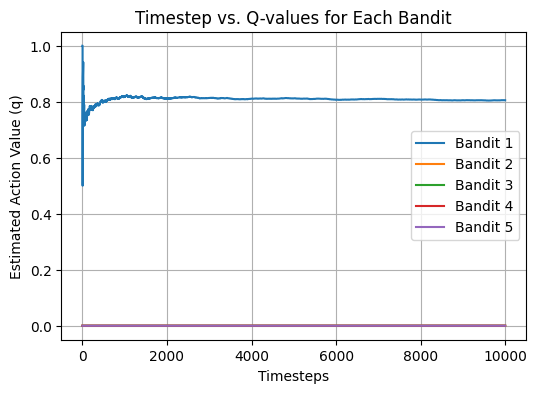


Plotting Q-values for c = 0.1 (first)


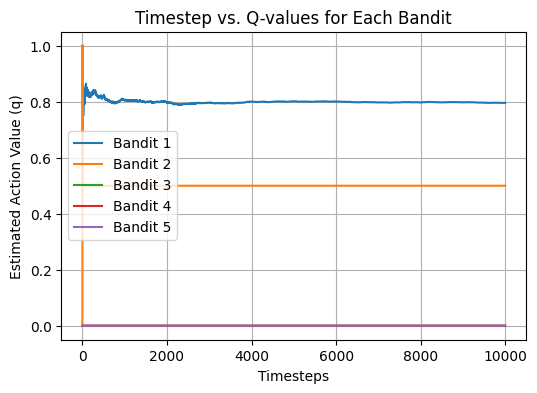


Plotting Q-values for c = 0.5 (first)


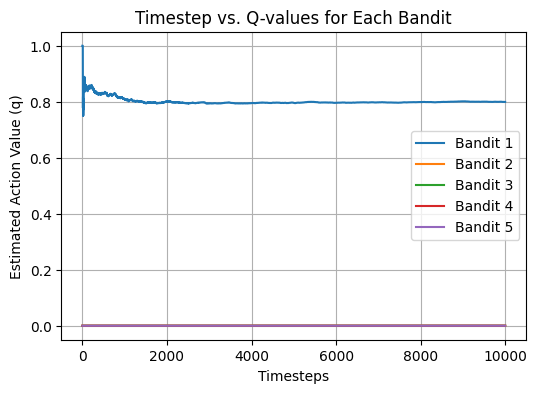


Plotting Q-values for c = 1 (first)


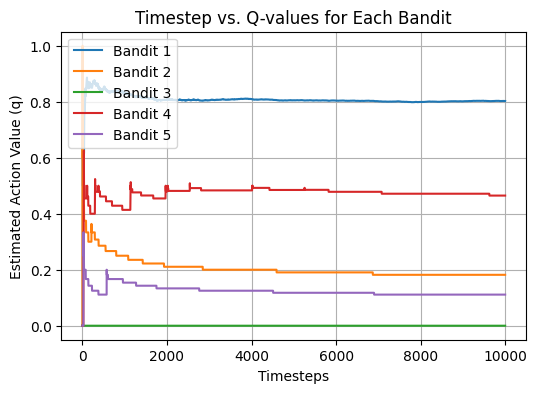


Plotting Q-values for c = 2 (first)


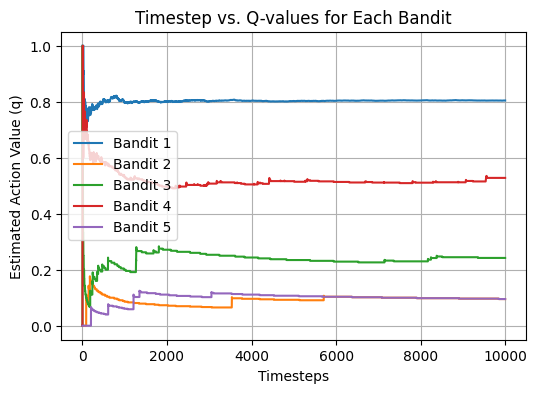


Plotting Q-values for c = 5 (first)


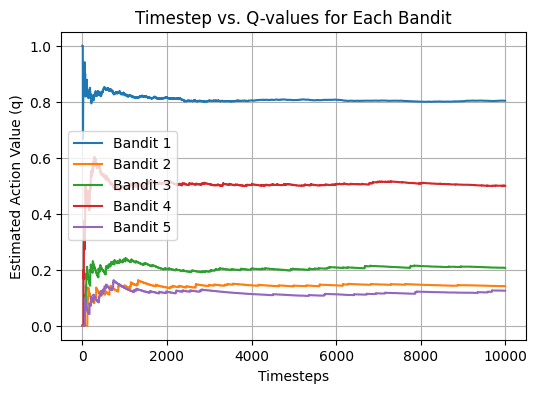


Plotting Q-values for c = 7 (first)


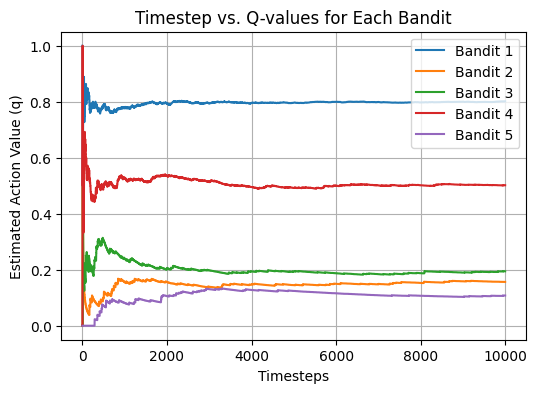


Plotting Q-values for c = 10 (first)


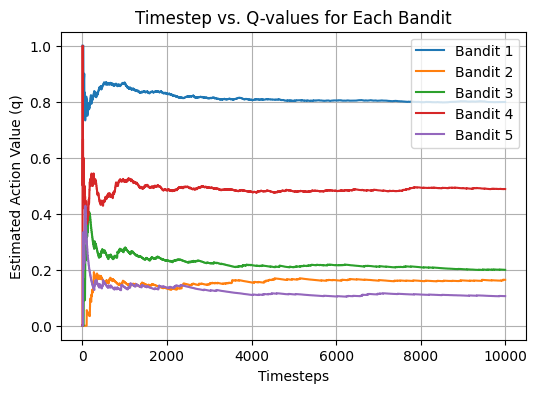

In [12]:
if __name__ == "__main__":

    cumulative_rewards_results = {}
    actions_selected_results = {}
    q_values_history_results = {}

    cumulative_rewards_results1 = {}
    actions_selected_results1 = {}
    q_values_history_results1 = {}

    cumulative_rewards_results2 = {}
    actions_selected_results2 = {}
    q_values_history_results2 = {}

    n_bandits = 5     
    n_steps = 10000 
    c_values = [0, 0.01, 0.1, 0.5, 1, 2, 5,7,10]
    
    method = "UCB"  

    for c in c_values:
        rewards = [0.1, 0.15, 0.2, 0.5, 0.8] 
        custom_rewards = rewards.copy()
        rewards, cumulative_rewards, hidden_rewards, actions_selected, q_values_history = run_experiment(
            n_bandits=n_bandits, n_steps=n_steps, c=c, method=method, custom_rewards=custom_rewards
        )
        cumulative_rewards_results[c] = cumulative_rewards
        actions_selected_results[c] = actions_selected
        q_values_history_results[c] = q_values_history
        print(f"c = {c}: Average reward = {np.mean(rewards):.2f}")
    
    for c in c_values:
        rewards = [0.1, 0.15, 0.8, 0.5, 0.2] 
        custom_rewards = rewards.copy()
        rewards, cumulative_rewards, hidden_rewards, actions_selected, q_values_history = run_experiment(
            n_bandits=n_bandits, n_steps=n_steps, c=c, method=method, custom_rewards=custom_rewards
        )
        cumulative_rewards_results1[c] = cumulative_rewards
        actions_selected_results1[c] = actions_selected
        q_values_history_results1[c] = q_values_history
        print(f"c = {c}: Average reward = {np.mean(rewards):.2f}")

    for c in c_values:
        rewards = [0.8, 0.15, 0.2, 0.5, 0.1] 
        custom_rewards = rewards.copy()
        rewards, cumulative_rewards, hidden_rewards, actions_selected, q_values_history = run_experiment(
            n_bandits=n_bandits, n_steps=n_steps, c=c, method=method, custom_rewards=custom_rewards
        )
        cumulative_rewards_results2[c] = cumulative_rewards
        actions_selected_results2[c] = actions_selected
        q_values_history_results2[c] = q_values_history
        print(f"c = {c}: Average reward = {np.mean(rewards):.2f}")

    # --- Plot กราฟเดิม (Cumulative Rewards & Actions) ---
    def plot_results(cumulative_results, actions_results, title):
        fig, axes = plt.subplots(1, 2, figsize=(20, 6))

        # --- Plot Cumulative Rewards ---
        for c, cumulative_rewards in cumulative_results.items():
            axes[0].plot(range(len(cumulative_rewards)), cumulative_rewards, label=f"c = {c}")

        axes[0].axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
        axes[0].set_title(f"{title} Performance of Agent Using {method}")
        axes[0].set_xlabel("Timesteps")
        axes[0].set_ylabel("Cumulative Average Reward")
        axes[0].legend()
        axes[0].grid()

        # --- Compute and Plot Cumulative Average of Selected Actions ---
        for c, actions_selected in actions_results.items():
            timesteps = np.arange(1, len(actions_selected) + 1)
            cumulative_avg_actions = np.cumsum(actions_selected) / timesteps  

            axes[1].plot(timesteps, cumulative_avg_actions, label=f"c = {c}", alpha=0.7)

        axes[1].set_title(f"{title} Cumulative Average Action Over Time")
        axes[1].set_xlabel("Timesteps")
        axes[1].set_ylabel("Cumulative Average Selected Action")
        axes[1].legend()
        axes[1].grid()

        plt.tight_layout()
        plt.show()

    # Plot กราฟเดิม
    plot_results(cumulative_rewards_results, actions_selected_results, "Last")
    plot_results(cumulative_rewards_results1, actions_selected_results1, "Middle")
    plot_results(cumulative_rewards_results2, actions_selected_results2, "First")

    # --- Plot Q-values ---
    for c in c_values:
        print(f"\nPlotting Q-values for c = {c}(Last)")
        plot_q_values(q_values_history_results[c], n_bandits)

    for c in c_values:
        print(f"\nPlotting Q-values for c = {c} (middle)")
        plot_q_values(q_values_history_results1[c], n_bandits)

    for c in c_values:
        print(f"\nPlotting Q-values for c = {c} (first)")
        plot_q_values(q_values_history_results2[c], n_bandits)


### Result Analysis

#### 1.the highest reward is associated with the last option [0.1, 0.15, 0.2, 0.5, **0.8**] 
Time Step 10000

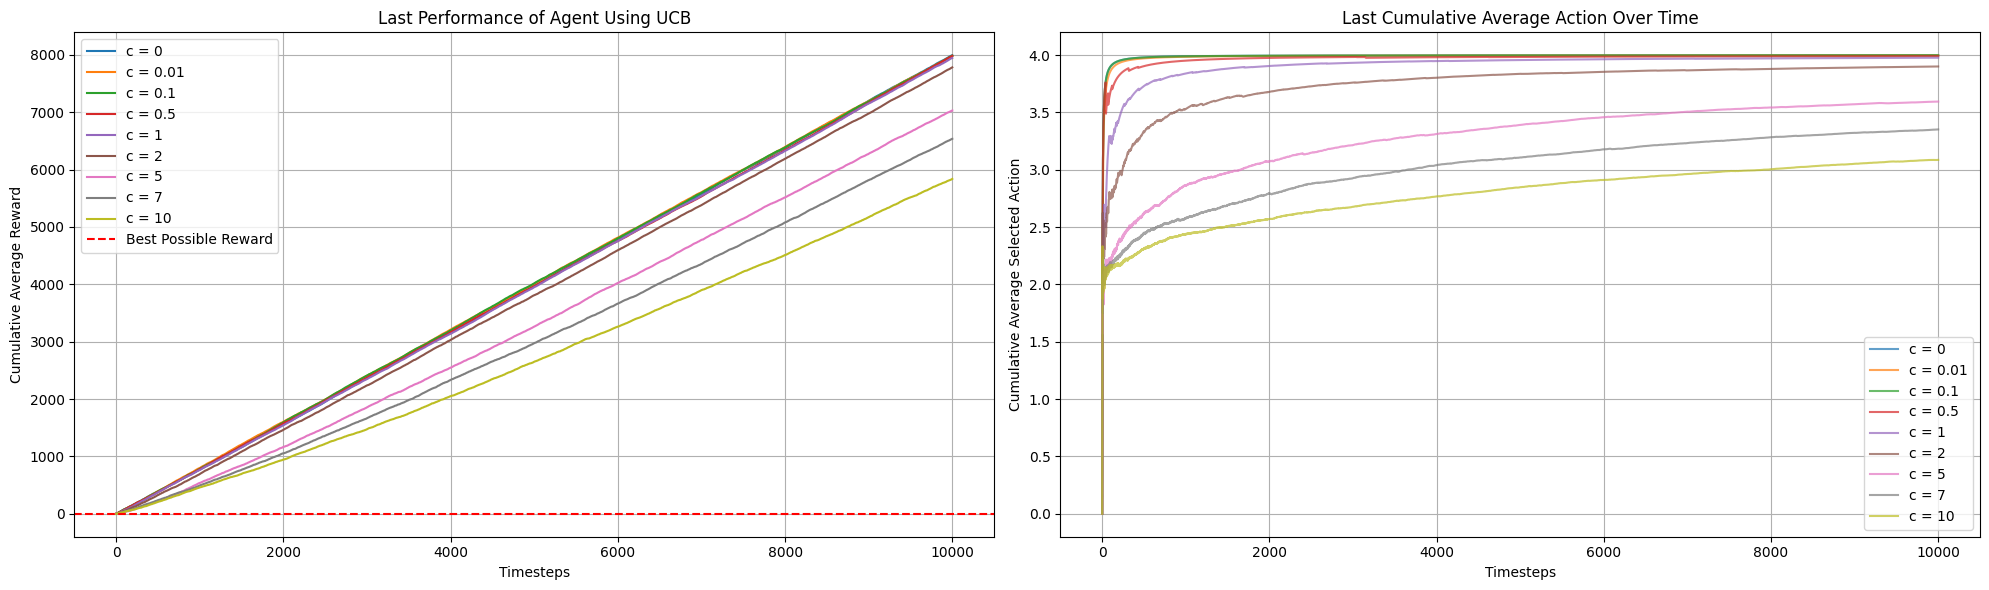

In this experiment, the Bandit problem is designed with hidden reward distributions as follows
[0.1, 0.15, 0.2, 0.5, 0.8], where the highest reward is associated with the last option.

From the results, we observe that

C-value = 1,10

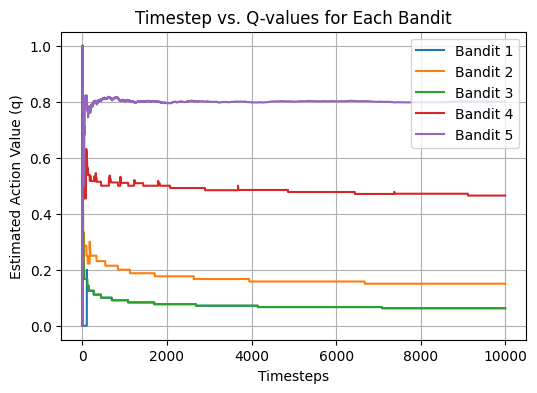 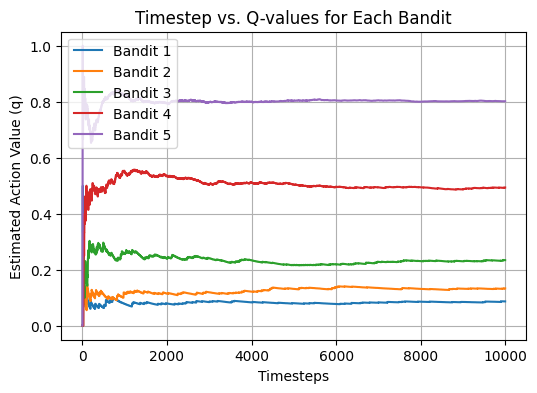
- When C-value >= 1 Agent start to expolring more, the agent discovers the machine with the highest hidden reward. However, since it continues exploring indefinitely instead of exploiting the best option, the cumulative reward remains low.

**Best Epsilon for This Case**

C-Value = 0, 0.01, 0.5

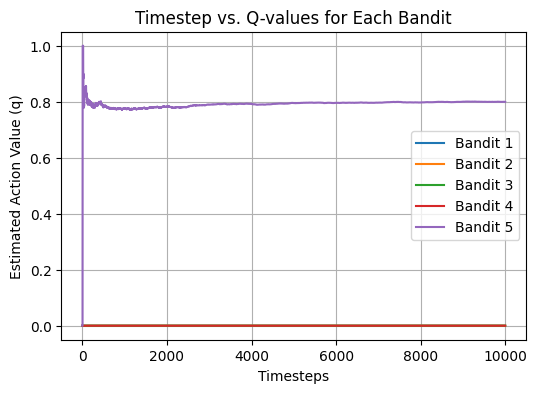 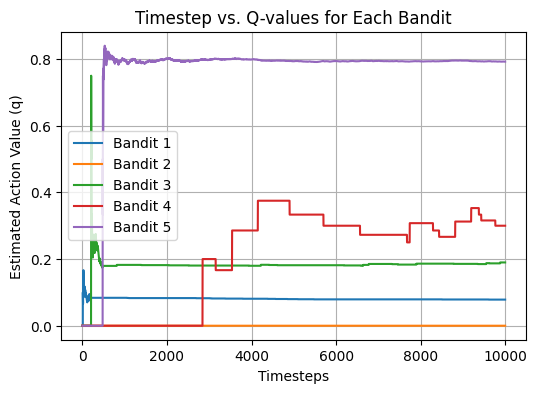 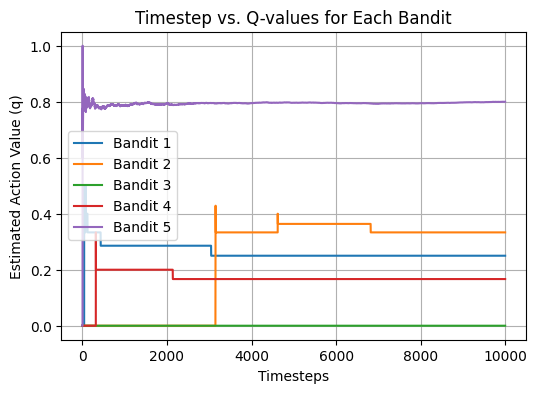

- C-Value = 0, 0.01, 0.1, 0.5 gives the highest cumulative reward. These values help the agent explore enough to find the best machine but still focus on using it efficiently.

#### 2. the highest reward is associated with the third option (middle position) [0.1, 0.15, **0.8**, 0.5, 0.2] 
Time Step 10000

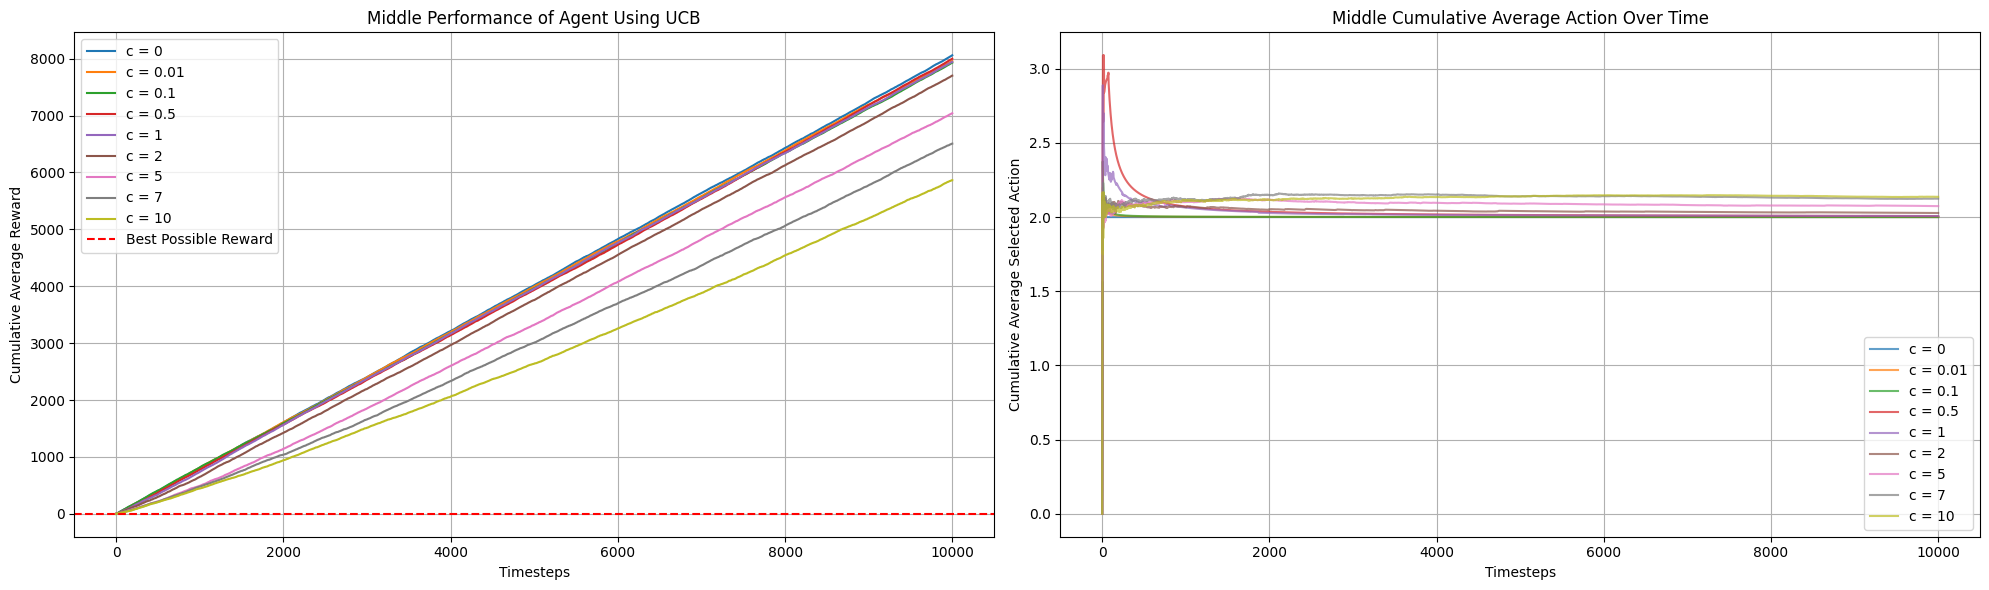

In this experiment, the Bandit problem is designed with hidden reward distributions as follows
[0.1, 0.15, 0.8, 0.5, 0.2], where the highest reward is associated with the middle option.

From the results, we observe that

C-value = 2,10

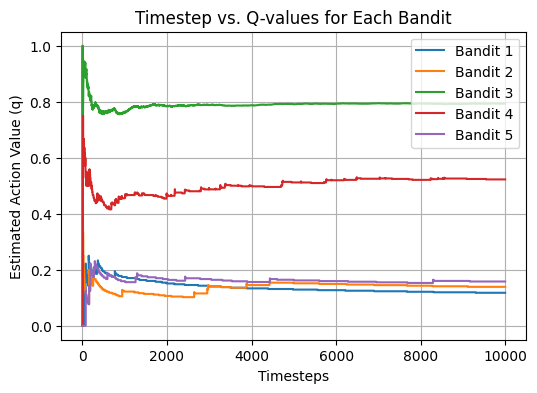 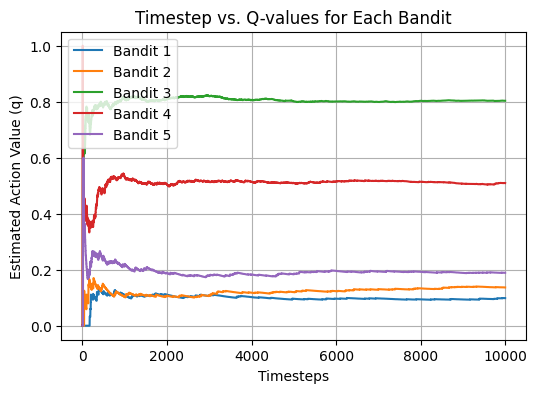
- When C-value >= 2 Agent start to expolring more, the agent discovers the machine with the highest hidden reward. However, since it continues exploring indefinitely instead of exploiting the best option, the cumulative reward remains low.

**Best Epsilon for This Case**

C-Value = 0, 0.01, 1

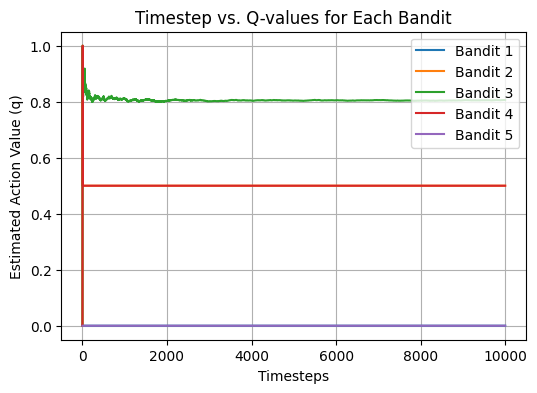 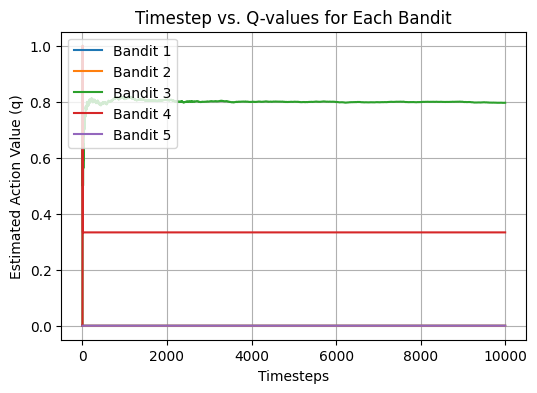 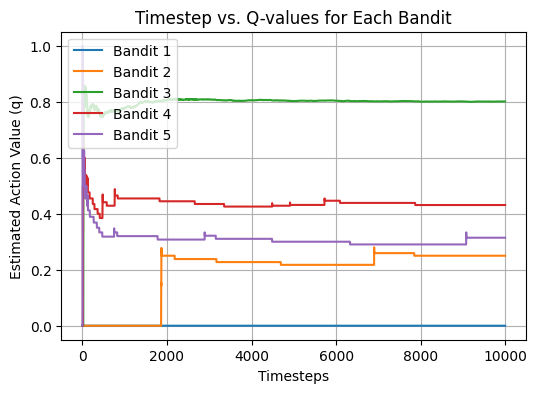

- C-Value = 0, 0.01, 0.1, 0.5, 1 gives the highest cumulative reward. These values help the agent explore enough to find the best machine but still focus on using it efficiently.

#### 3. the highest reward is associated with the first option [**0.8**, 0.15, 0.2, 0.5, 0.1] 
Time Step 10000

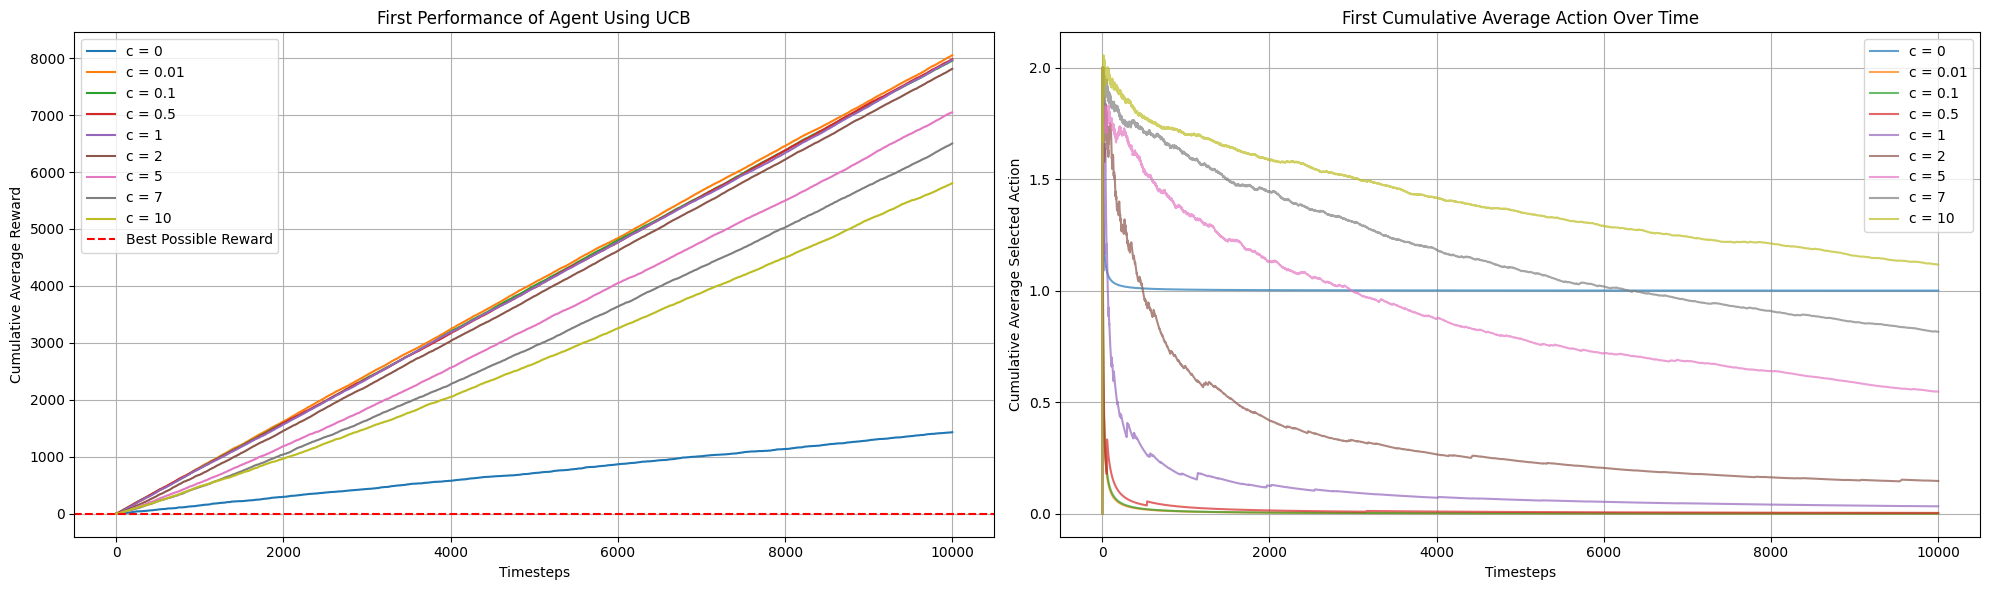

In this experiment, the Bandit problem is designed with hidden reward distributions as follows
[0.8, 0.15, 0.2, 0.5, 0.1] , where the highest reward is associated with the middle option.

From the results, we observe that

C-value = 0

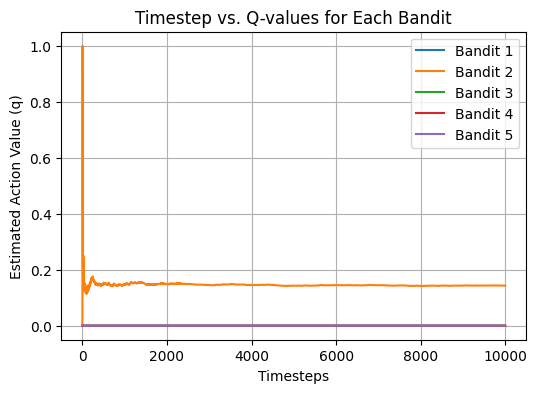
- When C-value = 0, (no exploration at all), the agent selects the machine that initially provides the highest reward it encounters. It does not attempt to explore further, resulting in a low cumulative reward since it fails to discover the best machine.

C-value = 2,10

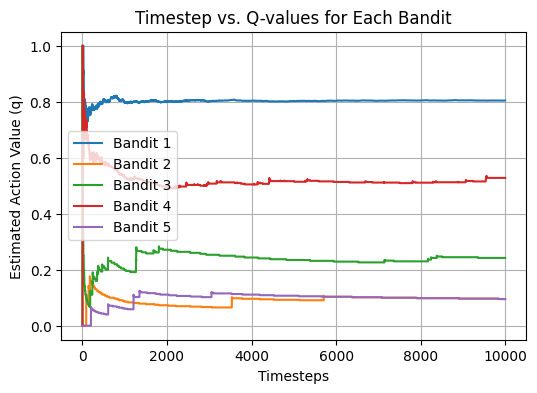 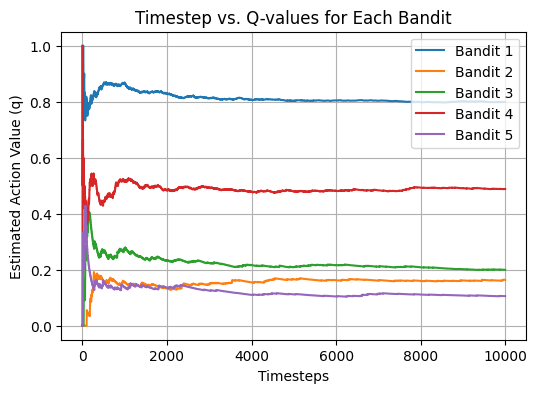
- When C-value >= 2 Agent start to expolring more, the agent discovers the machine with the highest hidden reward. However, since it continues exploring indefinitely instead of exploiting the best option, the cumulative reward remains low.

**Best Epsilon for This Case**

C-Value = 0.01, 1

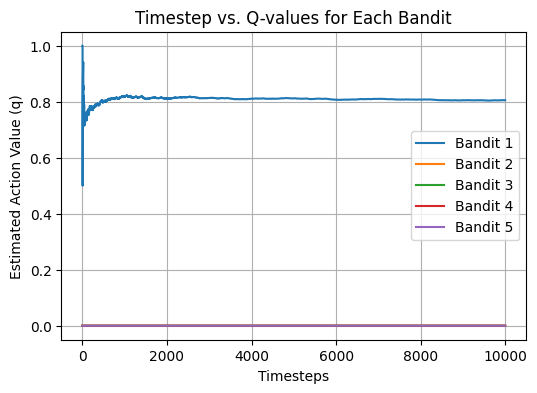 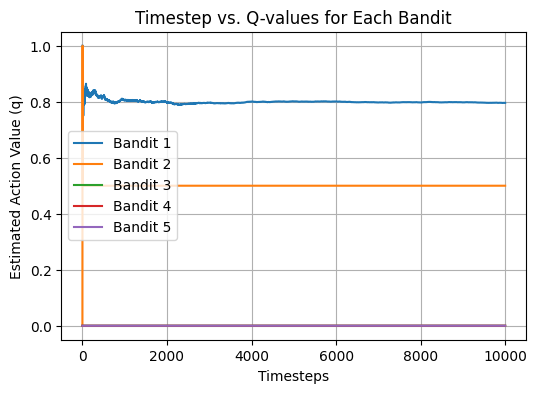

- C-Value = 0.01, 0.1, 0.5, 1 gives the highest cumulative reward. These values help the agent explore enough to find the best machine but still focus on using it efficiently.

## Summary of UCB
- The experimental results show that when the C-value approaches 0, the agent balances exploration and exploitation well, leading to higher cumulative rewards. This effect is observed in the range of 0.01 to 1.
- If the C-value exceeds 1, cumulative rewards start to decrease due to excessive exploration.
- When C = 0, although bandits with the highest reward located at the middle or end receive high cumulative rewards, the first bandit with the highest reward performs poorly, Maybe It cause by it too exploit.

**Implications for Multi-Armed Bandit Optimization**
In static environments, a well-tuned UCB strategy (C-Value ≈ 0.01 - 1) ensures efficient learning, allowing the agent to explore early and exploit once the best arm is identified.

# Epsilon-Greedy VS UCB
 If we comparing epsilon-greedy and UCB results we observe that UCB achieves a higher reward and get closer to maximum possible reward compared to epsilon-greedy, and we Hypothesis that Epsilon-Greedy is uses random exploration, so it sometimes wasted time exploring a bad actions and can even when it should, it might still explore some action, but UCB if confident value is less it will exploit only so its more efficiently.

Epsilon-Greedy 

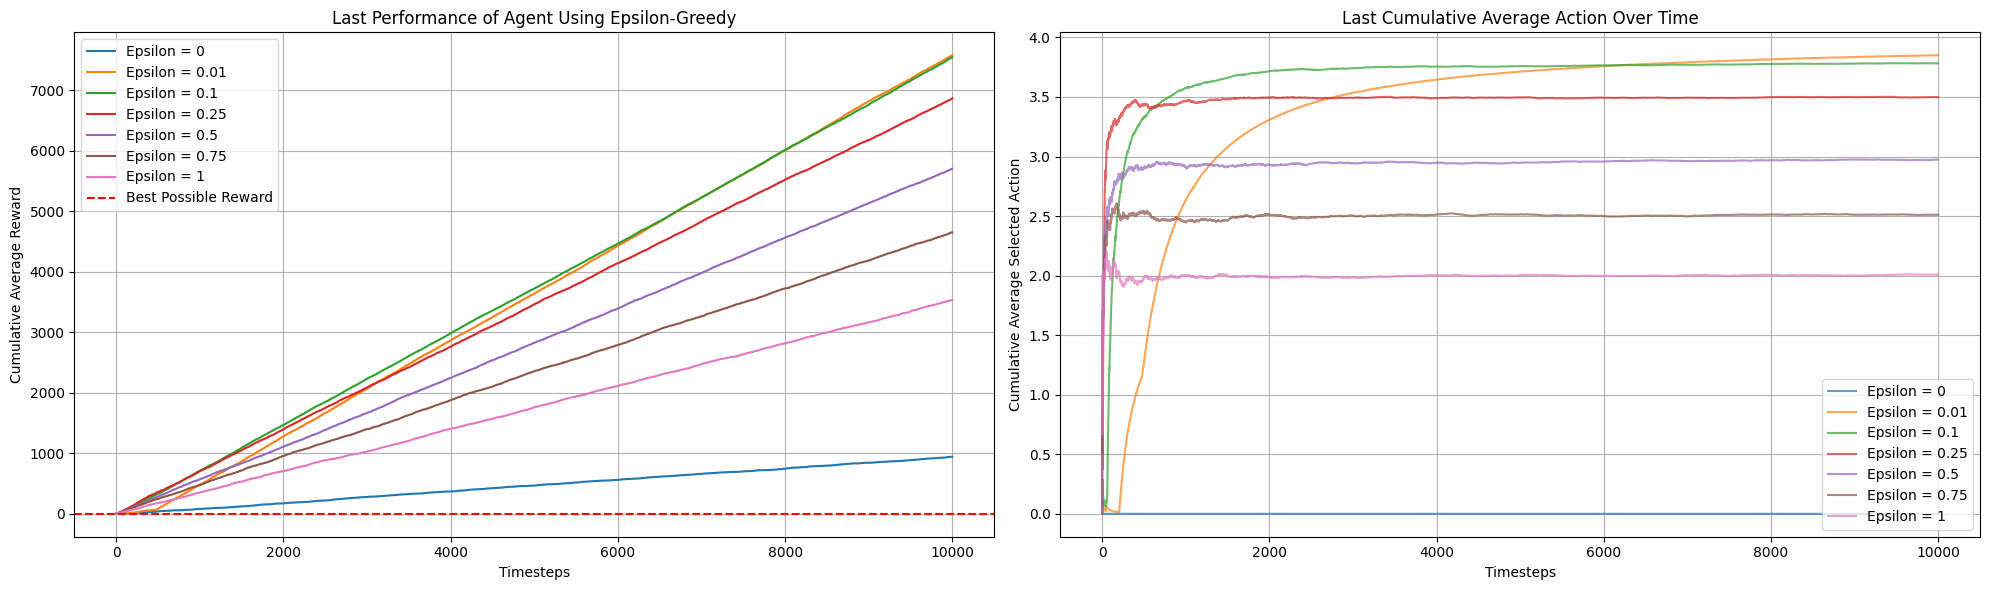

UCB

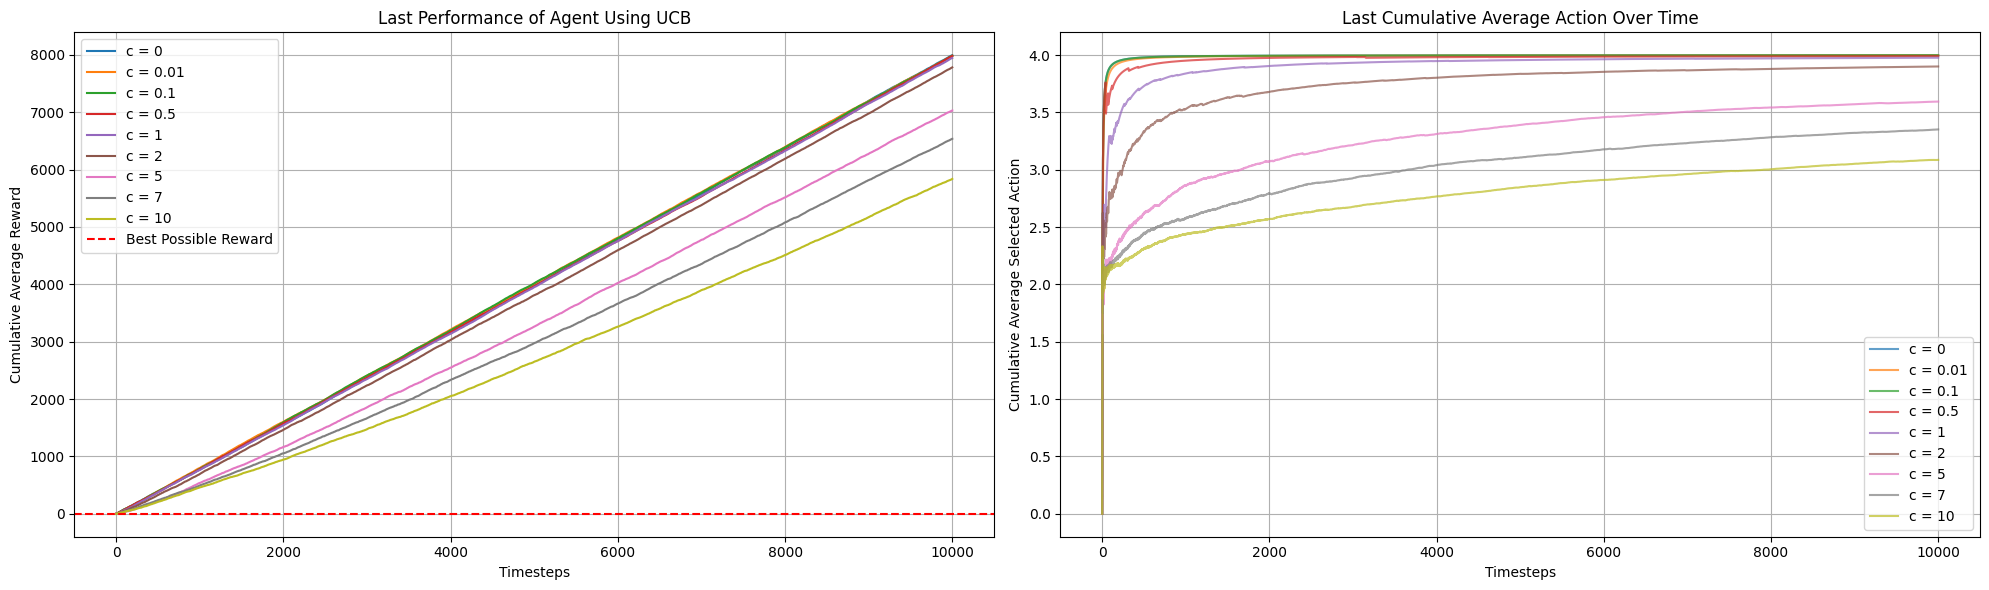